### Содержание

1. [Как получать контекст последовательности с помощью pyfaidx](#Как-получать-контекст-последовательности-с-помощью-pyfaidx)
2. [Подготовка датафреймов](#Подготовка-датафреймов)  
   2.1 [Фильтруем общий датафрейм](#Фильтруем-общий-датафрейм)  
   2.2 [Добавляем метрику LOEUF](#Добавляем-метрику-LOEUF)
3. [Разделение вариантов по значению патогенности](#Разделение-вариантов-по-значению-патогенности)  
   3.1 [Разделение по AC и LOEUF](#Разделение-по-AC-и-LOEUF)  
   3.2 [Убираем из условно доброкачественных вариантов все паты по Clinvar](#Убираем-из-условно-доброкачественных-вариантов-все-паты-Clinvar)  
   3.3 [Добавляем в условно патогенные варианты все непопуляционные паты Clinvar](#Добавляем-в-условно-патогенные-варианты-все-непопуляционные-паты-Clinvar)  
4. [Получение контекста последовательности](#Получение-контекста-последовательности)  
5. [Построение лого с помощью logomaker](#Построение-лого-с-помощью-logomaker)  
6. [Статистическое сравнение позиций в контекстах](#Статистическое-сравнение-позиций-в-контекстах)  

In [1]:
import datetime
import logomaker as lm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import seqlogo

from pyfaidx import Fasta
from scipy.stats import chi2_contingency
from os.path import join

### Как получать контекст последовательности с помощью pyfaidx

https://pypi.org/project/pyfaidx/

Загружаем нашу фасту с транскриптами, на этом этапе создается индекс fai.  

Дополнительно кастомизируем ключи, т.к. в файле траснкриптов ключи выглядят так:  
`ENST00000353265.8|ENSG00000178184.16|OTTHUMG00000132922.4|OTTHUMT00000256435.3|PARD6G-201|PARD6G|3836|protein_coding|`  
А нам нужна только их первая часть.

Тут бесячий момент: надо переархивировать файл с транскриптами в BGZF  
_Compressed FASTA is only supported in BGZF format. Use the samtools bgzip utility (instead of gzip) to compress your FASTA._  

<font color='brown'> Похоже, важно иметь версию >0.7.0, т.к. с ней какие-то проблемы: несмотря на перевод файла в BGZF формат, ошибка о неправильно инпуте не пропадала. А после апдейта до v.0.8.1.1 всё сработало.

Интересующий транскрипт и позиция:

Индексация с 0, поэтому чтобы получить позицию 34, вводим 33:

Утилита работает как словарь, тогда по примеру из документации:

Тут вызвали комплементарную позицию.

Проверила глазами по таблице, всё сходится.

### Получение NMD(-) регионов

Тестим nmd-escape из статьи Torene et al., 2024  

https://doi.org/10.1016/j.ajhg.2023.11.007  
https://github.com/rebeccaito/nmd-escape/tree/main

In [2]:
from annotating_nmd import * 

! `zcat gencode.v45.annotation.gtf.gz | awk 'OFS="\t" {if ($3=="CDS") {print $1,$4-1,$5,$12,$6,$7}}' | tr -d '";' > gencode.v45.annotation.bed`

In [3]:
cds_bed_df = pd.read_table('data_dir/gencode_data/gencode.v45.annotation.bed', names=['chrom', 'start', 'end', 'cds_id', 'score', 'strand'])

cds_bed_df['cds_id'] = (cds_bed_df['cds_id'] + '_cds_0_0_' +
                              cds_bed_df['chrom'] + '_' +
                              (cds_bed_df['start'] + 1).astype(str) + '_' +
                              cds_bed_df['strand'].map({'+': 'f', '-': 'r'}))

In [4]:
cds_bed_df

,chrom,start,end,cds_id,score,strand
0,chr1,65564,65573,ENST00000641515.2_cds_0_0_chr1_65565_f,.,+
1,chr1,69036,70005,ENST00000641515.2_cds_0_0_chr1_69037_f,.,+
2,chr1,450742,451678,ENST00000426406.4_cds_0_0_chr1_450743_r,.,-
3,chr1,685718,686654,ENST00000332831.5_cds_0_0_chr1_685719_r,.,-
4,chr1,924431,924948,ENST00000616016.5_cds_0_0_chr1_924432_f,.,+
...,...,...,...,...,...,...
885744,chrM,10469,10763,ENST00000361335.1_cds_0_0_chrM_10470_f,.,+
885745,chrM,10759,12137,ENST00000361381.2_cds_0_0_chrM_10760_f,.,+
885746,chrM,12336,14145,ENST00000361567.2_cds_0_0_chrM_12337_f,.,+
885747,chrM,14148,14673,ENST00000361681.2_cds_0_0_chrM_14149_r,.,-


Determine NMD regions from a 6-column bed file of coding sequence regions:

In [5]:
nmd_bed_df = make_boundaries_df(cds_bed_df)

In [6]:
nmd_bed_df

index  chrom      start        end  \
transcript_name                                             
ENST00000000233.10 0  358020   chr7  127591212  127591296   
                   1  358019   chr7  127591033  127591088   
ENST00000000412.8  0  528168  chr12    8941820    8941940   
                   1  528167  chr12    8942415    8942470   
ENST00000000442.11 0  493539  chr11   64315706   64315963   
...                      ...    ...        ...        ...   
ENST00000713920.1  1  649116  chr16    1320462    1320517   
ENST00000713921.1  0  649156  chr16    1324729    1324790   
                   1  649155  chr16    1320462    1320517   
ENST00000713922.1  0  649327  chr16    1314756    1314858   
                   1  649326  chr16    1314321    1314376   

                                                           cds_id score  \
transcript_name                                                           
ENST00000000233.10 0  ENST00000000233.10_cds_0_0_chr7_127591213_f     .   
                   1  ENST00000000233.10_cds_0_0_chr7_127590963_f     .   
ENST00000000412.8  0    ENST00000000412.8_cds_0_0_chr12_8941821_r     .   
                   1    ENST00000000412.8_cds_0_0_chr12_8942416_r     .   
ENST00000000442.11 0  ENST00000000442.11_cds_0_0_chr11_64315707_f     .   
...                                                           ...   ...   
ENST00000713920.1  1    ENST00000713920.1_cds_0_0_chr16_1320438_f     .   
ENST00000713921.1  0    ENST00000713921.1_cds_0_0_chr16_1324730_f     .   
                   1    ENST00000713921.1_cds_0_0_chr16_1320438_f     .   
ENST00000713922.1  0    ENST00000713922.1_cds_0_0_chr16_1314757_f     .   
                   1    ENST00000713922.1_cds_0_0_chr16_1314293_f     .   

                     strand     transcript_name cds_size  
transcript_name                                           
ENST00000000233.10 0      +  ENST00000000233.10       84  
                   1      +  ENST00000000233.10       55  
ENST00000000412.8  0      -   ENST00000000412.8      120  
                   1      -   ENST00000000412.8       55  
ENST00000000442.11 0      +  ENST00000000442.11      257  
...                     ...                 ...      ...  
ENST00000713920.1  1      +   ENST00000713920.1       55  
ENST00000713921.1  0      +   ENST00000713921.1       61  
                   1      +   ENST00000713921.1       55  
ENST00000713922.1  0      +   ENST00000713922.1      102  
                   1      +   ENST00000713922.1       55  

[213979 rows x 9 columns]

### Подготовка датафреймов

Преобразуем имеющиеся таблицы в датафреймы и объединяем всё в один датафрейм.

In [7]:
DATA_PATH = "data_dir/canonical_ensemble"

In [8]:
chromosomes = ['chr' + str(i) for i in range(1, 23)]
frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]

final_df = pd.concat(frames)

/tmp/ipykernel_1860944/1917723234.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]
/tmp/ipykernel_1860944/1917723234.py:2: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]
/tmp/ipykernel_1860944/1917723234.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exomes.v4.0.sites.{chromosome}.vcf.tsv")) for chromosome in chromosomes]
/tmp/ipykernel_1860944/1917723234.py:2: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  frames = [pd.read_table(join(DATA_PATH, f"gnomad.exom

In [9]:
final_df.shape

(67528142, 14)

In [10]:
final_df.dtypes

Chr                     object
Position                 int64
rsID                    object
Ref                     object
Alt                     object
Impact                  object
Consequence             object
Gene_symbol             object
Canonical_transcript    object
cDNA_position           object
LoF                     object
LoF_flag                object
LoF_filter              object
AC                       int64
dtype: object

In [11]:
final_df = final_df.rename(columns={'Chr': 'CHROM', 'Position': 'POS', 'Ref': 'REF', 'Alt': 'ALT'})

In [12]:
final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC
0,chr1,12541,.,C,G,"MODIFIER, MODIFIER, MODIFIER","intron_variant&non_coding_transcript_variant, ...","DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,1
1,chr1,12591,rs1553119381,C,T,"MODIFIER, MODIFIER, MODIFIER","intron_variant&non_coding_transcript_variant, ...","DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,5
2,chr1,12592,.,C,T,"MODIFIER, MODIFIER, MODIFIER","intron_variant&non_coding_transcript_variant, ...","DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,5
3,chr1,12599,rs1437963543,CT,C,"LOW, MODIFIER, MODIFIER",splice_polypyrimidine_tract_variant&intron_var...,"DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",NaN,NaN,NaN,NaN,14
4,chr1,12612,rs1205998786,GGT,G,"LOW, MODIFIER, MODIFIER",splice_region_variant&non_coding_transcript_ex...,"DDX11L1, WASH7P, MIR6859-1","ENST00000450305, ENST00000488147, ENST00000619216",98-99,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1621633,chr22,50799702,rs4081531,G,A,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,377
1621634,chr22,50799821,rs149733995,A,C,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,11
1621635,chr22,50801218,rs368061391,G,A,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,1
1621636,chr22,50801236,rs113976139,C,G,MODIFIER,downstream_gene_variant,RPL23AP82,ENST00000427528,NaN,NaN,NaN,NaN,18


#### Фильтруем общий датафрейм

Оставляем только однонуклеотидные стопгейны.

In [396]:
lof_final_df = final_df[final_df['Consequence'] == 'stop_gained']
lof_final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC
199,chr1,69548,rs1211934440,T,A,HIGH,stop_gained,OR4F5,ENST00000641515,581,HC,NaN,NaN,1
4666,chr1,925933,rs1409697303,A,T,HIGH,stop_gained,SAMD11,ENST00000616016,1038,HC,NaN,NaN,1
4692,chr1,925960,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1065,HC,NaN,NaN,1
4728,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,HC,NaN,NaN,2
5071,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,HC,NaN,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619819,chr22,50769106,rs559977293,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,715,HC,NaN,NaN,173
1620148,chr22,50769969,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,534,HC,NaN,NaN,1
1620665,chr22,50775796,rs1555923164,G,T,HIGH,stop_gained,RABL2B,ENST00000691320,462,HC,NaN,NaN,1
1620705,chr22,50775845,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,413,HC,NaN,NaN,2


Удалим все строки, где нет названия транскрипта в "Canonical_transcript" или там стоит два и больше названий:

In [397]:
lof_final_df = lof_final_df.dropna(subset=['Canonical_transcript'])
lof_final_df = lof_final_df[~lof_final_df['Canonical_transcript'].str.contains(',')]

In [398]:
lof_final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC
199,chr1,69548,rs1211934440,T,A,HIGH,stop_gained,OR4F5,ENST00000641515,581,HC,NaN,NaN,1
4666,chr1,925933,rs1409697303,A,T,HIGH,stop_gained,SAMD11,ENST00000616016,1038,HC,NaN,NaN,1
4692,chr1,925960,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1065,HC,NaN,NaN,1
4728,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,HC,NaN,NaN,2
5071,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,HC,NaN,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619819,chr22,50769106,rs559977293,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,715,HC,NaN,NaN,173
1620148,chr22,50769969,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,534,HC,NaN,NaN,1
1620665,chr22,50775796,rs1555923164,G,T,HIGH,stop_gained,RABL2B,ENST00000691320,462,HC,NaN,NaN,1
1620705,chr22,50775845,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,413,HC,NaN,NaN,2


In [399]:
lof_final_df['Consequence'].unique()

array(['stop_gained'], dtype=object)

In [400]:
lof_final_df['POS'].nunique()

296210

#### Добавляем метрику LOEUF

Для этого сначала переводим скачанный файл с метриками в датафрейм.

In [18]:
lof_metrics_by_gene = pd.read_table('../raw_data/plof_metrics/gnomad.v2.1.1.lof_metrics.by_gene.txt')
lof_metrics_by_gene

,gene,transcript,obs_mis,exp_mis,oe_mis,mu_mis,possible_mis,obs_mis_pphen,exp_mis_pphen,oe_mis_pphen,...,gene_type,gene_length,exac_pLI,exac_obs_lof,exac_exp_lof,exac_oe_lof,brain_expression,chromosome,start_position,end_position
0,MED13,ENST00000397786,871,1117.80,0.77921,0.000056,14195,314.0,529.750,0.59273,...,protein_coding,122678,1.000000e+00,0.0,64.3930,0.000000,NaN,17,60019966,60142643
1,NIPBL,ENST00000282516,846,1441.50,0.58688,0.000074,18540,158.0,543.100,0.29092,...,protein_coding,189655,1.000000e+00,1.0,110.5700,0.009044,NaN,5,36876861,37066515
2,SMC3,ENST00000361804,178,630.07,0.28251,0.000032,8109,21.0,182.520,0.11506,...,protein_coding,36946,1.000000e+00,0.0,58.5230,0.000000,NaN,10,112327449,112364394
3,CNOT1,ENST00000317147,561,1295.90,0.43290,0.000069,15670,51.0,290.680,0.17545,...,protein_coding,109936,1.000000e+00,3.0,90.1300,0.033285,NaN,16,58553855,58663790
4,RLF,ENST00000372771,669,972.87,0.68766,0.000047,12682,107.0,321.140,0.33319,...,protein_coding,79549,1.000000e+00,0.0,43.6070,0.000000,NaN,1,40627045,40706593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19699,OR7G2,ENST00000305456,177,181.12,0.97723,0.000009,2247,34.0,38.175,0.89064,...,protein_coding,1038,7.093800e-03,3.0,2.9635,1.012300,NaN,19,9212945,9213982
19700,OR7G3,ENST00000305444,164,163.92,1.00050,0.000008,2016,40.0,39.403,1.01520,...,protein_coding,939,4.059600e-01,1.0,4.8401,0.206610,NaN,19,9236688,9237626
19701,OR8D1,ENST00000357821,178,162.04,1.09850,0.000008,2002,65.0,54.179,1.19970,...,protein_coding,1026,2.159200e-01,1.0,2.7436,0.364480,NaN,11,124179708,124180733
19702,ZNF600,ENST00000338230,450,357.84,1.25750,0.000018,4794,138.0,124.070,1.11220,...,protein_coding,22597,1.477300e-13,16.0,9.6420,1.659400,NaN,19,53267448,53290044


In [19]:
lof_metrics_by_gene.columns

Index(['gene', 'transcript', 'obs_mis', 'exp_mis', 'oe_mis', 'mu_mis',
       'possible_mis', 'obs_mis_pphen', 'exp_mis_pphen', 'oe_mis_pphen',
       'possible_mis_pphen', 'obs_syn', 'exp_syn', 'oe_syn', 'mu_syn',
       'possible_syn', 'obs_lof', 'mu_lof', 'possible_lof', 'exp_lof', 'pLI',
       'pNull', 'pRec', 'oe_lof', 'oe_syn_lower', 'oe_syn_upper',
       'oe_mis_lower', 'oe_mis_upper', 'oe_lof_lower', 'oe_lof_upper',
       'constraint_flag', 'syn_z', 'mis_z', 'lof_z', 'oe_lof_upper_rank',
       'oe_lof_upper_bin', 'oe_lof_upper_bin_6', 'n_sites', 'classic_caf',
       'max_af', 'no_lofs', 'obs_het_lof', 'obs_hom_lof', 'defined', 'p',
       'exp_hom_lof', 'classic_caf_afr', 'classic_caf_amr', 'classic_caf_asj',
       'classic_caf_eas', 'classic_caf_fin', 'classic_caf_nfe',
       'classic_caf_oth', 'classic_caf_sas', 'p_afr', 'p_amr', 'p_asj',
       'p_eas', 'p_fin', 'p_nfe', 'p_oth', 'p_sas', 'transcript_type',
       'gene_id', 'transcript_level', 'cds_length', 'num_codi

In [20]:
lof_metrics_by_gene.columns.get_loc('oe_lof_upper')

29

Создаем словарь "транскрипт": "значение_loeuf".

In [21]:
loeuf_by_transcript_dict = dict(zip(lof_metrics_by_gene['transcript'], lof_metrics_by_gene['oe_lof_upper']))

In [22]:
loeuf_by_transcript_dict

{'ENST00000397786': 0.03,
 'ENST00000282516': 0.032,
 'ENST00000361804': 0.037,
 'ENST00000317147': 0.038,
 'ENST00000372771': 0.04,
 'ENST00000298281': 0.04,
 'ENST00000336824': 0.042,
 'ENST00000276072': 0.043,
 'ENST00000308488': 0.044,
 'ENST00000360982': 0.044,
 'ENST00000529006': 0.045,
 'ENST00000263377': 0.048,
 'ENST00000358691': 0.048,
 'ENST00000316623': 0.049,
 'ENST00000401558': 0.051,
 'ENST00000418929': 0.051,
 'ENST00000324545': 0.051,
 'ENST00000379059': 0.051,
 'ENST00000418600': 0.052,
 'ENST00000314191': 0.052,
 'ENST00000345617': 0.052,
 'ENST00000446231': 0.053,
 'ENST00000253048': 0.054,
 'ENST00000371817': 0.055,
 'ENST00000429416': 0.055,
 'ENST00000337273': 0.056,
 'ENST00000373204': 0.057,
 'ENST00000404338': 0.057,
 'ENST00000243077': 0.058,
 'ENST00000361337': 0.059,
 'ENST00000283943': 0.06,
 'ENST00000311117': 0.06,
 'ENST00000310441': 0.06,
 'ENST00000302904': 0.06,
 'ENST00000342160': 0.06,
 'ENST00000314358': 0.06,
 'ENST00000359863': 0.06,
 'ENST00000

Запишем в столбец LOEUF все совпадения по ключам-транскриптам.

In [401]:
lof_final_df.loc[:, 'LOEUF'] = lof_final_df['Canonical_transcript'].map(loeuf_by_transcript_dict)

In [402]:
lof_final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
199,chr1,69548,rs1211934440,T,A,HIGH,stop_gained,OR4F5,ENST00000641515,581,HC,NaN,NaN,1,NaN
4666,chr1,925933,rs1409697303,A,T,HIGH,stop_gained,SAMD11,ENST00000616016,1038,HC,NaN,NaN,1,NaN
4692,chr1,925960,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1065,HC,NaN,NaN,1,NaN
4728,chr1,925996,.,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1101,HC,NaN,NaN,2,NaN
5071,chr1,930221,rs934852613,C,T,HIGH,stop_gained,SAMD11,ENST00000616016,1185,HC,NaN,NaN,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619819,chr22,50769106,rs559977293,G,A,HIGH,stop_gained,RABL2B,ENST00000691320,715,HC,NaN,NaN,173,NaN
1620148,chr22,50769969,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,534,HC,NaN,NaN,1,NaN
1620665,chr22,50775796,rs1555923164,G,T,HIGH,stop_gained,RABL2B,ENST00000691320,462,HC,NaN,NaN,1,NaN
1620705,chr22,50775845,.,C,T,HIGH,stop_gained,RABL2B,ENST00000691320,413,HC,NaN,NaN,2,NaN


Посмотрим, какие значения записались и сверим, совпадает ли с исходным файлом **(upd: да)**

In [403]:
lof_final_df[lof_final_df['LOEUF'].notna()]

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
13302,chr1,951173,.,G,T,HIGH,stop_gained,NOC2L,ENST00000327044,1413,HC,NaN,NaN,2,1.327
13323,chr1,951207,rs967128892,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1379,HC,NaN,NaN,53,1.327
13329,chr1,951214,rs1181426236,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1372,HC,NaN,NaN,1,1.327
13625,chr1,952022,rs1399402693,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1325,HC,NaN,NaN,4,1.327
13676,chr1,952087,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1260,HC,NaN,NaN,2,1.327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618565,chr22,50744863,rs372608841,C,T,HIGH,stop_gained,ACR,ENST00000216139,954,LC,NaN,END_TRUNC,6,0.880
1618575,chr22,50744878,rs776906749,C,T,HIGH,stop_gained,ACR,ENST00000216139,969,LC,NaN,END_TRUNC,9,0.880
1618614,chr22,50744938,rs1327549675,C,T,HIGH,stop_gained,ACR,ENST00000216139,1029,LC,NaN,END_TRUNC,4,0.880
1618624,chr22,50744953,rs769944788,C,T,HIGH,stop_gained,ACR,ENST00000216139,1044,LC,NaN,END_TRUNC,13,0.880


In [404]:
print(lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000327044', 'oe_lof_upper'].values[0], '\n',
lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000216139', 'oe_lof_upper'].values[0])

1.327 
 0.88


In [27]:
print(lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000370783', 'oe_lof_upper'].values[0], '\n',
lof_metrics_by_gene.loc[lof_metrics_by_gene['transcript'] == 'ENST00000262213', 'oe_lof_upper'].values[0])

0.361 
 0.361


Удалим все строки, где нет LOEUF (т.к. для нас они бессмысленны и всё равно удалятся при делении на пат/бен):

In [405]:
lof_final_df = lof_final_df.dropna(subset=['LOEUF'])

In [406]:
lof_final_df.shape

(210663, 15)

Оставляем только высококонсервативные варианты:

In [ ]:
lof_final_df = lof_final_df[lof_final_df['LOEUF'] < 0.35]

#### Добавляем метрику pext

In [465]:
import pyliftover

In [409]:
header_pext = ['chrom', 'pos', 'ref', 'alt', 'tx_annotation']

In [466]:
pext_raw_df = pd.read_table("data_dir/pext/stop_gained_rows.tsv", names=header_pext)

/tmp/ipykernel_1860944/4201993334.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  pext_raw_df = pd.read_table("data_dir/pext/stop_gained_rows.tsv", names=header_pext)


In [467]:
tx_annotation_data = pext_raw_df['tx_annotation'].apply(lambda x: json.loads(x.replace("'", "\""))[0])
pext_tx_annotation = pd.DataFrame(tx_annotation_data.tolist())
pext_final = pd.concat([pext_raw_df.drop(columns=['tx_annotation']), pext_tx_annotation], axis=1)

In [468]:
pext_final = pext_final[(pext_final['chrom'] != 'X') & (pext_final['chrom'] != 'Y')]

In [469]:
pext_hg38_final = pext_final.copy()
pext_hg38_final['chrom'] = pext_hg38_final['chrom'].apply(lambda x: 'chr' + str(x))

In [470]:
lo = pyliftover.LiftOver('hg19', 'hg38')

for index, row in pext_hg38_final.iterrows():
    try:
        converted = lo.convert_coordinate(row['chrom'], row['pos'])
        if converted:
            pext_hg38_final.loc[index, 'chrom'] = converted[0][0]
            pext_hg38_final.loc[index, 'pos'] = converted[0][1]
    except Exception as e:
        print(f"Error converting coordinates for index {index}: {e}")

In [476]:
# cols_to_avg = ['Cells_Transformedfibroblasts', 'Prostate', 'Spleen',
#        'Brain_FrontalCortex_BA9_', 'SmallIntestine_TerminalIleum',
#        'MinorSalivaryGland', 'Artery_Coronary', 'Skin_SunExposed_Lowerleg_',
#        'Cells_EBV_transformedlymphocytes', 'Brain_Hippocampus',
#        'Esophagus_Muscularis', 'Brain_Nucleusaccumbens_basalganglia_',
#        'Artery_Tibial', 'Brain_Hypothalamus', 'Adipose_Visceral_Omentum_',
#        'Cervix_Ectocervix', 'Brain_Spinalcord_cervicalc_1_',
#        'Brain_CerebellarHemisphere', 'Nerve_Tibial', 'Breast_MammaryTissue',
#        'Liver', 'Skin_NotSunExposed_Suprapubic_', 'AdrenalGland', 'Vagina',
#        'Pancreas', 'Lung', 'FallopianTube', 'Pituitary', 'Muscle_Skeletal',
#        'Colon_Transverse', 'Artery_Aorta', 'Heart_AtrialAppendage',
#        'Adipose_Subcutaneous', 'Esophagus_Mucosa', 'Heart_LeftVentricle',
#        'Brain_Cerebellum', 'Brain_Cortex', 'Thyroid', 'Brain_Substantianigra',
#        'Kidney_Cortex', 'Uterus', 'Stomach', 'WholeBlood', 'Bladder',
#        'Brain_Anteriorcingulatecortex_BA24_', 'Brain_Putamen_basalganglia_',
#        'Brain_Caudate_basalganglia_', 'Colon_Sigmoid', 'Cervix_Endocervix',
#        'Ovary', 'Esophagus_GastroesophagealJunction', 'Testis',
#        'Brain_Amygdala']

# row_index = 4190803

# pext_hg38_final.loc[row_index, cols_to_avg].mean(skipna=True)  # совпадает с mean_proportion

In [471]:
pext_dict = {(row['chrom'], row['pos'], row['ref'], row['alt']): row['mean_proportion'] for _, row in pext_hg38_final.iterrows()}

In [472]:
len(pext_dict)

4184730

In [473]:
for index, row in lof_final_df.iterrows():
    key = (row['CHROM'], row['POS'], row['REF'], row['ALT'])
    
    if key in pext_dict:
        lof_final_df.loc[index, 'pext'] = pext_dict[key]
    else:
        lof_final_df.loc[index, 'pext'] = None

In [474]:
lof_final_df['pext'].notna().sum()

209386

In [475]:
lof_final_df.shape

(210663, 16)

Оставляем только более высокоэкспрессирующиеся варианты:

In [479]:
lof_final_df['pext'] = lof_final_df['pext'].astype(float)
lof_final_df = lof_final_df[lof_final_df['pext'] > 0.5]

/tmp/ipykernel_1860944/1152817119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lof_final_df['pext'] = lof_final_df['pext'].astype(float)


In [480]:
lof_final_df.shape

(147517, 16)

In [481]:
lof_final_df['pext'].notna().sum()

147517

### Разделение на NMD_escape(+) и NMD_escape(-) датафреймы

Для удобства уберем группировку по `transcript_name`:

In [30]:
nmd_bed_df

index  chrom      start        end  \
transcript_name                                             
ENST00000000233.10 0  358020   chr7  127591212  127591296   
                   1  358019   chr7  127591033  127591088   
ENST00000000412.8  0  528168  chr12    8941820    8941940   
                   1  528167  chr12    8942415    8942470   
ENST00000000442.11 0  493539  chr11   64315706   64315963   
...                      ...    ...        ...        ...   
ENST00000713920.1  1  649116  chr16    1320462    1320517   
ENST00000713921.1  0  649156  chr16    1324729    1324790   
                   1  649155  chr16    1320462    1320517   
ENST00000713922.1  0  649327  chr16    1314756    1314858   
                   1  649326  chr16    1314321    1314376   

                                                           cds_id score  \
transcript_name                                                           
ENST00000000233.10 0  ENST00000000233.10_cds_0_0_chr7_127591213_f     .   
                   1  ENST00000000233.10_cds_0_0_chr7_127590963_f     .   
ENST00000000412.8  0    ENST00000000412.8_cds_0_0_chr12_8941821_r     .   
                   1    ENST00000000412.8_cds_0_0_chr12_8942416_r     .   
ENST00000000442.11 0  ENST00000000442.11_cds_0_0_chr11_64315707_f     .   
...                                                           ...   ...   
ENST00000713920.1  1    ENST00000713920.1_cds_0_0_chr16_1320438_f     .   
ENST00000713921.1  0    ENST00000713921.1_cds_0_0_chr16_1324730_f     .   
                   1    ENST00000713921.1_cds_0_0_chr16_1320438_f     .   
ENST00000713922.1  0    ENST00000713922.1_cds_0_0_chr16_1314757_f     .   
                   1    ENST00000713922.1_cds_0_0_chr16_1314293_f     .   

                     strand     transcript_name cds_size  
transcript_name                                           
ENST00000000233.10 0      +  ENST00000000233.10       84  
                   1      +  ENST00000000233.10       55  
ENST00000000412.8  0      -   ENST00000000412.8      120  
                   1      -   ENST00000000412.8       55  
ENST00000000442.11 0      +  ENST00000000442.11      257  
...                     ...                 ...      ...  
ENST00000713920.1  1      +   ENST00000713920.1       55  
ENST00000713921.1  0      +   ENST00000713921.1       61  
                   1      +   ENST00000713921.1       55  
ENST00000713922.1  0      +   ENST00000713922.1      102  
                   1      +   ENST00000713922.1       55  

[213979 rows x 9 columns]

In [31]:
nmd_bed_df = nmd_bed_df.rename(columns={'transcript_name': 'transcript'})
nmd_bed_df = nmd_bed_df.reset_index()
nmd_bed_df = nmd_bed_df.drop('transcript_name', axis=1)

In [32]:
nmd_bed_df = nmd_bed_df.drop('level_1', axis=1)

In [33]:
nmd_bed_df = nmd_bed_df.drop('index', axis=1)

In [34]:
nmd_bed_df

,chrom,start,end,cds_id,score,strand,transcript,cds_size
0,chr7,127591212,127591296,ENST00000000233.10_cds_0_0_chr7_127591213_f,.,+,ENST00000000233.10,84
1,chr7,127591033,127591088,ENST00000000233.10_cds_0_0_chr7_127590963_f,.,+,ENST00000000233.10,55
2,chr12,8941820,8941940,ENST00000000412.8_cds_0_0_chr12_8941821_r,.,-,ENST00000000412.8,120
3,chr12,8942415,8942470,ENST00000000412.8_cds_0_0_chr12_8942416_r,.,-,ENST00000000412.8,55
4,chr11,64315706,64315963,ENST00000000442.11_cds_0_0_chr11_64315707_f,.,+,ENST00000000442.11,257
...,...,...,...,...,...,...,...,...
213974,chr16,1320462,1320517,ENST00000713920.1_cds_0_0_chr16_1320438_f,.,+,ENST00000713920.1,55
213975,chr16,1324729,1324790,ENST00000713921.1_cds_0_0_chr16_1324730_f,.,+,ENST00000713921.1,61
213976,chr16,1320462,1320517,ENST00000713921.1_cds_0_0_chr16_1320438_f,.,+,ENST00000713921.1,55
213977,chr16,1314756,1314858,ENST00000713922.1_cds_0_0_chr16_1314757_f,.,+,ENST00000713922.1,102


In [35]:
lof_final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF
13302,chr1,951173,.,G,T,HIGH,stop_gained,NOC2L,ENST00000327044,1413,HC,NaN,NaN,2,1.327
13323,chr1,951207,rs967128892,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1379,HC,NaN,NaN,53,1.327
13329,chr1,951214,rs1181426236,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1372,HC,NaN,NaN,1,1.327
13625,chr1,952022,rs1399402693,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1325,HC,NaN,NaN,4,1.327
13676,chr1,952087,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1260,HC,NaN,NaN,2,1.327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618565,chr22,50744863,rs372608841,C,T,HIGH,stop_gained,ACR,ENST00000216139,954,LC,NaN,END_TRUNC,6,0.880
1618575,chr22,50744878,rs776906749,C,T,HIGH,stop_gained,ACR,ENST00000216139,969,LC,NaN,END_TRUNC,9,0.880
1618614,chr22,50744938,rs1327549675,C,T,HIGH,stop_gained,ACR,ENST00000216139,1029,LC,NaN,END_TRUNC,4,0.880
1618624,chr22,50744953,rs769944788,C,T,HIGH,stop_gained,ACR,ENST00000216139,1044,LC,NaN,END_TRUNC,13,0.880


In [36]:
# def check_nmd_escape(row):
#     transcript = row['Canonical_transcript']
#     matching_transcripts = nmd_bed_df[nmd_bed_df['transcript'].str.split('.').str[0] == transcript]

#     if matching_transcripts.empty:
#         return 'NO_TRANSCRIPT'

#     else:
#         position = int(row['Position'])
#         for _, transcript_row in matching_transcripts.iterrows():
#             start = int(transcript_row['start'])
#             end = int(transcript_row['end'])
            
#             if start <= position <= end:
#                 return 'YES'
        
#         return 'NO'

In [37]:
# # всё совпало
# data1 = {
#     'Canonical_transcript': ['transcript1', 'transcript2', 'transcript2', 'transcript3', 'transcript4'],
#     'Position': [100, 200, 351, 300, 400],
#     'NMD': [''] * 5  # Инициализация колонки NMD пустыми значениями
# }

# data2 = {
#     'transcript_name': ['transcript1', 'transcript2', 'transcript2', 'transcript3'],
#     'start': [50, 151, 251, 400],
#     'end': [150, 250, 350, 500]
# }

# df1 = pd.DataFrame(data1)
# df2 = pd.DataFrame(data2)

# df1['NMD'] = df1.apply(check_nmd_escape, axis=1)
# df1

In [38]:
# new_nmd_bed_df = nmd_bed_df.sample(n=10000)
# new_lof_final_df = lof_final_df.sample(n=10000)

In [39]:
# %%time

# new_lof_final_df['NMD_escape'] = new_lof_final_df.apply(check_nmd_escape, axis=1)

`new_lof_final_df['NMD_escape'] = new_lof_final_df.apply(check_nmd_escape, axis=1)`

_CPU times: user 2min 11s, sys: 46.8 ms, total: 2min 12s  
Wall time: 2min 12s_
***
Код с `mask` на тех же данных:  
  
_CPU times: user 10 s, sys: 2.99 ms, total: 10 s  
Wall time: 10.1 s_

In [40]:
%%time

mask_transcript = lof_final_df['Canonical_transcript'].isin(nmd_bed_df['transcript'].str.split('.').str[0])
lof_final_df.loc[~mask_transcript, 'NMD_escape'] = 'NO_TRANSCRIPT'

for index, row in nmd_bed_df.iterrows():
    transcript_split = row['transcript'].split('.')[0]
    
    mask_all = (lof_final_df['Canonical_transcript'] == transcript_split) & \
             (lof_final_df['POS'] >= row['start']) & \
             (lof_final_df['POS'] <= row['end'])
    
    lof_final_df.loc[mask_all, 'NMD_escape'] = 'YES'


lof_final_df.loc[(lof_final_df['NMD_escape'] != 'YES') & (lof_final_df['NMD_escape'] != 'NO_TRANSCRIPT'), 'NMD_escape'] = 'NO'

<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 44min 13s, sys: 2.69 s, total: 44min 16s
Wall time: 44min 34s


In [41]:
lof_final_df

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,NMD_escape
13302,chr1,951173,.,G,T,HIGH,stop_gained,NOC2L,ENST00000327044,1413,HC,NaN,NaN,2,1.327,NO
13323,chr1,951207,rs967128892,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1379,HC,NaN,NaN,53,1.327,NO
13329,chr1,951214,rs1181426236,G,C,HIGH,stop_gained,NOC2L,ENST00000327044,1372,HC,NaN,NaN,1,1.327,NO
13625,chr1,952022,rs1399402693,G,A,HIGH,stop_gained,NOC2L,ENST00000327044,1325,HC,NaN,NaN,4,1.327,NO
13676,chr1,952087,.,C,T,HIGH,stop_gained,NOC2L,ENST00000327044,1260,HC,NaN,NaN,2,1.327,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618565,chr22,50744863,rs372608841,C,T,HIGH,stop_gained,ACR,ENST00000216139,954,LC,NaN,END_TRUNC,6,0.880,YES
1618575,chr22,50744878,rs776906749,C,T,HIGH,stop_gained,ACR,ENST00000216139,969,LC,NaN,END_TRUNC,9,0.880,YES
1618614,chr22,50744938,rs1327549675,C,T,HIGH,stop_gained,ACR,ENST00000216139,1029,LC,NaN,END_TRUNC,4,0.880,YES
1618624,chr22,50744953,rs769944788,C,T,HIGH,stop_gained,ACR,ENST00000216139,1044,LC,NaN,END_TRUNC,13,0.880,YES


In [42]:
lof_final_df['NMD_escape'].unique()

array(['NO', 'YES', 'NO_TRANSCRIPT'], dtype=object)

In [43]:
#lof_final_df.to_csv('lof_final_df_nmd.csv', index=False)

In [44]:
# new_nmd_bed_df[new_nmd_bed_df['transcript'].str.contains('ENST00000343516')]

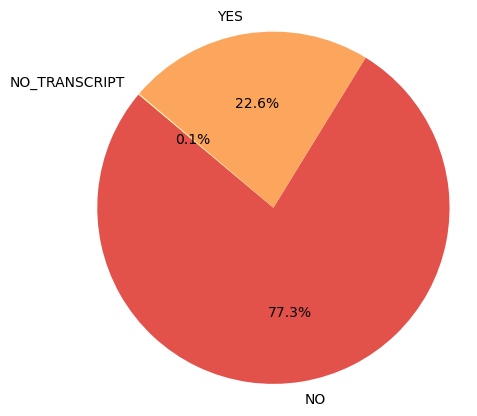

In [45]:
nmd_counts = lof_final_df['NMD_escape'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(nmd_counts, 
        labels=nmd_counts.index, 
        autopct='%1.1f%%', 
        startangle=140,
        colors=sns.color_palette("Spectral")) 
plt.axis('equal')
plt.show()


In [46]:
nmd_esc_df = lof_final_df[lof_final_df['NMD_escape'] == 'YES']
nmd_df = lof_final_df[lof_final_df['NMD_escape'] == 'NO']

In [47]:
nmd_esc_df.shape

(47528, 16)

In [48]:
nmd_df.shape

(162928, 16)

### Разделение вариантов по значению патогенности

Для начала создадим датафреймы для пат/непат (условно).  
  
Важно оставить только высококонсервативные варианты, для этого поставим отсечку по LOEUF (в гномаде 2 она составляет 0,35). Нет LOEUF - нет варианта.

Как я предлагаю это делать:  
* **условно патогенные**  
   Отсечка в AC < 2. Плюс можно пересечь с ClinVar и записать в список варианты пат/лпат, которые отсутcтвуют в GnomAD v.4, но есть в ClinVar, так мы расширим список патов.
    
* **условно доброкачественные**  
  Отсечка в AC >= 2 (согласно свежим рекомендациям ACGS, критерий BS2). В таком случае у нас может остаться много АР вариантов, их я предлагаю убрать. Для этого можно полученный условно доброкачественный список сопоставить с ClinVar и удалить все пересечения с зарегистрированными пат/лпат вариантами.

The loss-of-function observed over expected upper bound fraction, or LOEUF score, is a metric that places each gene on a continuous scale of loss-of-function constraint. Low scores are highly correlated with disease genes and gene essentiality (https://doi.org/10.1007/s00439-022-02509-x). 
  
Due to expected shifts in the LOEUF distribution between gnomAD v2.1.1 and v4.0, we now recommend a threshold of LOEUF < 0.6 for v4.0 (compared to LOEUF < 0.35 for v2). (https://gnomad.broadinstitute.org/news/2024-03-gnomad-v4-0-gene-constraint/#loeuf-guidance)

В ClinVar не указаны транскрипты, поэтому проаннотируем скачанный файл Clinvar (версия для GRCh38) с помощью vep.  
`./vep -i ../clinvar/clinvar_20240331.vcf -o ../clinvar/clinvar_20240331_anno.vcf --vcf --canonical --cache`

#### Разделение по AC и LOEUF

Разнесём общий датафрейм (здесь `nmd_esc_df`) на `pat_nmd_escape` и `ben_nmd_escape`.

**Условно патогенные**:

In [49]:
pat_nmd_escape = nmd_esc_df.query('AC < 2')
pat_nmd_escape

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,NMD_escape
210760,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439,HC,NaN,NaN,1,0.194,YES
211245,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558,HC,NaN,NaN,1,0.194,YES
211254,chr1,2306700,.,C,T,HIGH,stop_gained,SKI,ENST00000378536,2570,HC,NaN,NaN,1,0.194,YES
211258,chr1,2306707,.,G,A,HIGH,stop_gained,SKI,ENST00000378536,2577,HC,NaN,NaN,1,0.194,YES
211278,chr1,2306724,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2594,HC,NaN,NaN,1,0.194,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297779,chr22,43204096,.,G,T,HIGH,stop_gained,SCUBE1,ENST00000360835,2979,HC,NaN,NaN,1,0.313,YES
1358300,chr22,44883208,.,C,A,HIGH,stop_gained,PHF21B,ENST00000313237,1930,HC,NaN,NaN,1,0.294,YES
1358304,chr22,44883214,.,G,A,HIGH,stop_gained,PHF21B,ENST00000313237,1924,HC,NaN,NaN,1,0.294,YES
1605180,chr22,50610725,.,C,G,HIGH,stop_gained,MAPK8IP2,ENST00000329492,2447,HC,NaN,NaN,1,0.100,YES


**Условно доброкачественные**:

In [50]:
ben_nmd_escape = nmd_esc_df.query('AC >= 2')
ben_nmd_escape

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,NMD_escape
193676,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,HC,NaN,NaN,7,0.245,YES
211250,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,HC,NaN,NaN,3,0.194,YES
268094,chr1,3432126,.,C,T,HIGH,stop_gained,PRDM16,ENST00000270722,3739,LC,NaN,END_TRUNC,2,0.187,YES
341550,chr1,6106422,rs753070352,G,A,HIGH,stop_gained,CHD5,ENST00000262450,6128,HC,NaN,NaN,6,0.157,YES
532061,chr1,10639061,rs1372435001,C,A,HIGH,stop_gained,CASZ1,ENST00000377022,5477,HC,NaN,NaN,4,0.152,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743200,chr22,31685769,rs1371496002,G,A,HIGH,stop_gained,PRR14L,ENST00000327423,6405,HC,NaN,NaN,6,0.277,YES
1092381,chr22,39684452,rs1285494384,G,A,HIGH,stop_gained,CACNA1I,ENST00000402142,5981,HC,NaN,NaN,6,0.202,YES
1093303,chr22,39686269,.,C,A,HIGH,stop_gained,CACNA1I,ENST00000402142,6536,LC,NaN,END_TRUNC,2,0.202,YES
1175029,chr22,41357424,.,G,T,HIGH,stop_gained,ZC3H7B,ENST00000352645,3183,HC,NaN,NaN,2,0.323,YES


#### Обработка датафрейма Clinvar

In [486]:
clinvar_df = pd.read_table('data_dir/clinvar/clinvar_20240331_anno.vcf.tsv')

In [487]:
clinvar_df

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,MC,Consequence,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,cDNA_position,CANONICAL
0,chr1,69134,2205837,A,G,Likely_benign,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,167,YES
1,chr1,69581,2252161,C,G,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,614,YES
2,chr1,69682,2396347,G,A,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,715,YES
3,chr1,69769,2288999,T,C,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,802,YES
4,chr1,69995,2351346,G,C,Uncertain_significance,single_nucleotide_variant,OR4F5:79501,SO:0001583|missense_variant,missense_variant,OR4F5,ENSG00000186092,Transcript,ENST00000641515,protein_coding,1028,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34840143,chrNT_187693.1,273806,2219599,G,A,Likely_benign,single_nucleotide_variant,LILRA3:11026,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34840144,chrNT_187693.1,273866,2237818,A,C,Uncertain_significance,single_nucleotide_variant,LILRA3:11026,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34840145,chrNT_187693.1,274366,2206666,G,C,Uncertain_significance,single_nucleotide_variant,LILRA3:11026,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34840146,chrNT_187693.1,275068,2241971,T,C,Uncertain_significance,single_nucleotide_variant,LILRA3:11026|LOC126057115:126057115,SO:0001583|missense_variant,intergenic_variant,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Оставим только варианты на каноническом транскрипте:

In [55]:
clinvar_canon_df = clinvar_df[clinvar_df['CANONICAL'] == 'YES']

Оставим только аутосомы:

In [56]:
clinvar_canon_df['CHROM'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22',
       'chrX', 'chrY'], dtype=object)

In [57]:
clinvar_canon_df = clinvar_canon_df[~clinvar_canon_df['CHROM'].isin(['chrMT', 'chrX', 'chrY', 'chrNT_113889.1'])]

In [58]:
clinvar_canon_df['CHROM'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22'],
      dtype=object)

Добавляем вариантам значение LOEUF и отбираем только условные высококонсервативные варианты:

In [488]:
clinvar_df.loc[:, 'LOEUF'] = clinvar_df['Feature'].map(loeuf_by_transcript_dict)

In [489]:
clinvar_df = clinvar_df.query('LOEUF < 0.35')

Добавляем метрику pext и отбираем только более экспрессирующиеся варианты:

In [493]:
for index, row in clinvar_df.iterrows():
    key = (row['CHROM'], row['POS'], row['REF'], row['ALT'])
    
    if key in pext_dict:
        clinvar_df.loc[index, 'pext'] = pext_dict[key]
    else:
        clinvar_df.loc[index, 'pext'] = None

In [496]:
clinvar_df['pext'].notna().sum()

15299

In [497]:
clinvar_df['pext'] = clinvar_df['pext'].astype(float)
clinvar_df = clinvar_df[clinvar_df['pext'] > 0.5]

In [498]:
clinvar_df['pext'].notna().sum()

10454

Уберём строки, в которых нет информации о транскрипте или позиции кДНК:

In [59]:
clinvar_canon_df = clinvar_canon_df.dropna(subset=['cDNA_position', 'Feature'])

Оставим только однонуклеотидные варианты:

In [60]:
clinvar_canon_df = clinvar_canon_df[~clinvar_canon_df['cDNA_position'].str.contains('-')]

Посмотрим, какие классы по клинической значимости у нас встречаются.

In [61]:
clinvar_canon_df[clinvar_canon_df['CLNSIG'].str.contains('pathogenic', case=False, na=False)]['CLNSIG'].unique()

array(['Likely_pathogenic', 'Pathogenic',
       'Conflicting_classifications_of_pathogenicity',
       'Pathogenic/Likely_pathogenic',
       'Conflicting_classifications_of_pathogenicity|association',
       'Likely_pathogenic|risk_factor',
       'Conflicting_classifications_of_pathogenicity|other',
       'Pathogenic/Likely_pathogenic/Pathogenic,_low_penetrance',
       'Pathogenic/Likely_pathogenic|other', 'Pathogenic|other',
       'Pathogenic/Likely_pathogenic|risk_factor',
       'Likely_pathogenic,_low_penetrance',
       'Conflicting_classifications_of_pathogenicity|drug_response',
       'Likely_pathogenic/Likely_risk_allele', 'Pathogenic|risk_factor',
       'Conflicting_classifications_of_pathogenicity|association|risk_factor',
       'Pathogenic/Pathogenic,_low_penetrance|other',
       'Pathogenic/Pathogenic,_low_penetrance|other|risk_factor',
       'Conflicting_classifications_of_pathogenicity|risk_factor',
       'Pathogenic|drug_response', 'Likely_pathogenic|protecti

In [62]:
clinvar_canon_df['Consequence'].unique()

array(['missense_variant', 'synonymous_variant',
       'missense_variant&splice_region_variant',
       'splice_region_variant&synonymous_variant', 'stop_gained',
       'frameshift_variant', 'stop_gained&splice_region_variant',
       '3_prime_UTR_variant', 'start_lost', '5_prime_UTR_variant',
       'stop_retained_variant', 'non_coding_transcript_exon_variant',
       'splice_region_variant&5_prime_UTR_variant', 'stop_lost',
       'frameshift_variant&splice_region_variant',
       'protein_altering_variant&splice_region_variant',
       'frameshift_variant&stop_lost', 'frameshift_variant&start_lost',
       'stop_gained&frameshift_variant', 'coding_sequence_variant',
       'splice_region_variant&3_prime_UTR_variant',
       'start_lost&splice_region_variant', 'protein_altering_variant',
       'inframe_insertion',
       'frameshift_variant&start_lost&start_retained_variant',
       'splice_region_variant&non_coding_transcript_exon_variant',
       'splice_region_variant&coding_se

In [63]:
clinvar_canon_df['MC'].unique()

array(['SO:0001583|missense_variant', 'SO:0001819|synonymous_variant',
       'SO:0001583|missense_variant,SO:0001627|intron_variant',
       'SO:0001587|nonsense', 'SO:0001589|frameshift_variant',
       'SO:0001624|3_prime_UTR_variant',
       'SO:0001582|initiator_codon_variant,SO:0001583|missense_variant',
       'SO:0001583|missense_variant,SO:0001624|3_prime_UTR_variant',
       'SO:0001623|5_prime_UTR_variant',
       'SO:0001583|missense_variant,SO:0001619|non-coding_transcript_variant',
       'SO:0001619|non-coding_transcript_variant,SO:0001819|synonymous_variant',
       'SO:0001587|nonsense,SO:0001619|non-coding_transcript_variant',
       'SO:0001627|intron_variant,SO:0001819|synonymous_variant',
       'SO:0001619|non-coding_transcript_variant,SO:0001624|3_prime_UTR_variant',
       'SO:0001583|missense_variant,SO:0001619|non-coding_transcript_variant,SO:0001623|5_prime_UTR_variant',
       'SO:0001619|non-coding_transcript_variant,SO:0001623|5_prime_UTR_variant,SO:000181

Оставим только стопгейны (в Clinvar - nonsense), отмеченные как пат/лпат.

In [64]:
clinvar_canon_df['CLNSIG'].isnull().sum()

0

In [65]:
# # удаляем затесавшуюся строку с пустым значением CLNSIG
# clinvar_final_pat = clinvar_canon_df.dropna(subset=['CLNSIG'])

# оставляем пат/лпат нонсенсы
clinvar_final_pat = clinvar_canon_df[
    clinvar_canon_df['CLNSIG'].str.contains('pathogenic') &
    ~clinvar_canon_df['CLNSIG'].str.contains('pathogenicity') &
    clinvar_canon_df['MC'].str.contains('nonsense') &
    clinvar_canon_df['Consequence'].str.contains('stop_gained')
]

clinvar_final_pat

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,MC,Consequence,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,cDNA_position,CANONICAL,LOEUF
29944,chr1,1049672,489335,C,T,Likely_pathogenic,single_nucleotide_variant,AGRN:375790,SO:0001587|nonsense,stop_gained,AGRN,ENSG00000188157,Transcript,ENST00000379370,protein_coding,4674,YES,0.435
31520,chr1,1050461,2584416,C,T,Pathogenic/Likely_pathogenic,single_nucleotide_variant,AGRN:375790,SO:0001587|nonsense,stop_gained,AGRN,ENSG00000188157,Transcript,ENST00000379370,protein_coding,5064,YES,0.435
42338,chr1,1232517,452846,G,A,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,281,YES,1.425
43250,chr1,1232959,806030,C,G,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,723,YES,1.425
43370,chr1,1233041,666963,C,T,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,805,YES,1.425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33487295,chr22,50626256,558645,G,A,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,stop_gained,ARSA,ENSG00000100299,Transcript,ENST00000216124,protein_coding,1250,YES,1.340
33488240,chr22,50626721,1423789,C,A,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,stop_gained,ARSA,ENSG00000100299,Transcript,ENST00000216124,protein_coding,1097,YES,1.340
33489500,chr22,50626992,371662,G,A,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,stop_gained,ARSA,ENSG00000100299,Transcript,ENST00000216124,protein_coding,899,YES,1.340
33490256,chr22,50627198,840281,G,A,Pathogenic/Likely_pathogenic,single_nucleotide_variant,ARSA:410,SO:0001587|nonsense,stop_gained,ARSA,ENSG00000100299,Transcript,ENST00000216124,protein_coding,806,YES,1.340


In [66]:
clinvar_final_pat['CLNSIG'].unique()

array(['Likely_pathogenic', 'Pathogenic/Likely_pathogenic',
       'Pathogenic/Likely_pathogenic|other', 'Likely_pathogenic|Affects',
       'Likely_pathogenic|risk_factor'], dtype=object)

In [67]:
clinvar_final_pat['cDNA_position'].isna().sum()

0

Расставим NMD+ и NMD-:

In [68]:
mask_transcript = clinvar_final_pat['Feature'].isin(nmd_bed_df['transcript'].str.split('.').str[0])
clinvar_final_pat.loc[~mask_transcript, 'NMD_escape'] = 'NO_TRANSCRIPT'

for index, row in nmd_bed_df.iterrows():
    transcript_split = row['transcript'].split('.')[0]
    
    mask_all = (clinvar_final_pat['Feature'] == transcript_split) & \
             (clinvar_final_pat['POS'] >= row['start']) & \
             (clinvar_final_pat['POS'] <= row['end'])
    
    clinvar_final_pat.loc[mask_all, 'NMD_escape'] = 'YES'


clinvar_final_pat.loc[(clinvar_final_pat['NMD_escape'] != 'YES') & (clinvar_final_pat['NMD_escape'] != 'NO_TRANSCRIPT'), 'NMD_escape'] = 'NO'

/tmp/ipykernel_1860944/84413560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinvar_final_pat.loc[~mask_transcript, 'NMD_escape'] = 'NO_TRANSCRIPT'


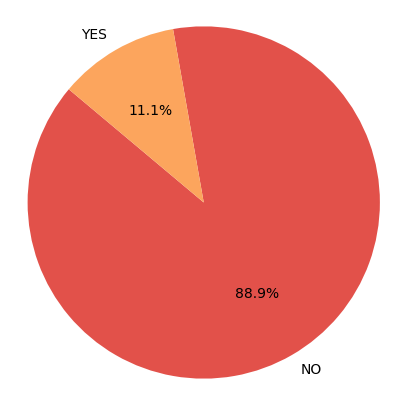

In [69]:
clinvar_nmd_counts = clinvar_final_pat['NMD_escape'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(clinvar_nmd_counts, 
        labels=clinvar_nmd_counts.index, 
        autopct='%1.1f%%', 
        startangle=140,
        colors=sns.color_palette("Spectral")) 
plt.axis('equal')
plt.show()


Сделаем отдельные датафреймы для NMD+ и NMD-:

In [70]:
clinvar_nmd_esc_df = clinvar_final_pat[clinvar_final_pat['NMD_escape'] == 'YES']
clinvar_nmd_df = clinvar_final_pat[clinvar_final_pat['NMD_escape'] == 'NO']

#### Убираем из условно доброкачественных вариантов все паты Clinvar

Теперь пересечём `clinvar_nmd_esc_df` и `ben_nmd_escape` и оставим в последнем только те варианты, которых нет в `clinvar_nmd_esc_df`.

Соединим два датафрейма, удалим все пересечения по `'CHROM'`, `'POS'`, `'REF'`, `'ALT'`, и затем удалим остатки `clinvar_nmd_esc_df` (т.е. удалим все строки, у которых не пусто в столбце `CLNSIG`).

In [71]:
clinvar_nmd_esc = clinvar_nmd_esc_df.rename(columns={'Feature': 'Canonical_transcript'})

In [72]:
merged_clinvar_and_ben = pd.concat([ben_nmd_escape, clinvar_nmd_esc], ignore_index=True)
merged_clinvar_and_ben

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,3432126,.,C,T,HIGH,stop_gained,PRDM16,ENST00000270722,3739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,6106422,rs753070352,G,A,HIGH,stop_gained,CHD5,ENST00000262450,6128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,10639061,rs1372435001,C,A,HIGH,stop_gained,CASZ1,ENST00000377022,5477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,chr22,26027013,NaN,C,T,NaN,stop_gained,NaN,ENST00000335473,7254,...,1324760.0,Likely_pathogenic,single_nucleotide_variant,MYO18B:84700,SO:0001587|nonsense,MYO18B,ENSG00000133454,Transcript,protein_coding,YES
2000,chr22,26457890,NaN,G,A,NaN,stop_gained,NaN,ENST00000398145,2512,...,2676123.0,Likely_pathogenic,single_nucleotide_variant,HPS4:89781,"SO:0001587|nonsense,SO:0001619|non-coding_tran...",HPS4,ENSG00000100099,Transcript,protein_coding,YES
2001,chr22,38112233,NaN,C,T,NaN,stop_gained,NaN,ENST00000332509,2561,...,1012697.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,PLA2G6:8398,SO:0001587|nonsense,PLA2G6,ENSG00000184381,Transcript,protein_coding,YES
2002,chr22,38112295,NaN,G,A,NaN,stop_gained,NaN,ENST00000332509,2499,...,1177288.0,Likely_pathogenic,single_nucleotide_variant,PLA2G6:8398,SO:0001587|nonsense,PLA2G6,ENSG00000184381,Transcript,protein_coding,YES


In [73]:
# не оставляем ни одну дублирующую строку
ben_nmd_escape_filtered = merged_clinvar_and_ben.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep=False)
ben_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,3432126,.,C,T,HIGH,stop_gained,PRDM16,ENST00000270722,3739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,6106422,rs753070352,G,A,HIGH,stop_gained,CHD5,ENST00000262450,6128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,10639061,rs1372435001,C,A,HIGH,stop_gained,CASZ1,ENST00000377022,5477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,chr22,26027013,NaN,C,T,NaN,stop_gained,NaN,ENST00000335473,7254,...,1324760.0,Likely_pathogenic,single_nucleotide_variant,MYO18B:84700,SO:0001587|nonsense,MYO18B,ENSG00000133454,Transcript,protein_coding,YES
2000,chr22,26457890,NaN,G,A,NaN,stop_gained,NaN,ENST00000398145,2512,...,2676123.0,Likely_pathogenic,single_nucleotide_variant,HPS4:89781,"SO:0001587|nonsense,SO:0001619|non-coding_tran...",HPS4,ENSG00000100099,Transcript,protein_coding,YES
2001,chr22,38112233,NaN,C,T,NaN,stop_gained,NaN,ENST00000332509,2561,...,1012697.0,Pathogenic/Likely_pathogenic,single_nucleotide_variant,PLA2G6:8398,SO:0001587|nonsense,PLA2G6,ENSG00000184381,Transcript,protein_coding,YES
2002,chr22,38112295,NaN,G,A,NaN,stop_gained,NaN,ENST00000332509,2499,...,1177288.0,Likely_pathogenic,single_nucleotide_variant,PLA2G6:8398,SO:0001587|nonsense,PLA2G6,ENSG00000184381,Transcript,protein_coding,YES


In [74]:
# убираем остатки клинвара
ben_nmd_escape_filtered = ben_nmd_escape_filtered[~ben_nmd_escape_filtered['CLNSIG'].notna()]
ben_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,ID,CLNSIG,CLNVC,GENEINFO,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,3432126,.,C,T,HIGH,stop_gained,PRDM16,ENST00000270722,3739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,6106422,rs753070352,G,A,HIGH,stop_gained,CHD5,ENST00000262450,6128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,10639061,rs1372435001,C,A,HIGH,stop_gained,CASZ1,ENST00000377022,5477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,chr22,31685769,rs1371496002,G,A,HIGH,stop_gained,PRR14L,ENST00000327423,6405,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1043,chr22,39684452,rs1285494384,G,A,HIGH,stop_gained,CACNA1I,ENST00000402142,5981,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1044,chr22,39686269,.,C,A,HIGH,stop_gained,CACNA1I,ENST00000402142,6536,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1045,chr22,41357424,.,G,T,HIGH,stop_gained,ZC3H7B,ENST00000352645,3183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
ben_nmd_escape_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'NMD_escape', 'ID', 'CLNSIG',
       'CLNVC', 'GENEINFO', 'MC', 'SYMBOL', 'Gene', 'Feature_type', 'BIOTYPE',
       'CANONICAL'],
      dtype='object')

In [76]:
ben_nmd_escape_filtered = ben_nmd_escape_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'SYMBOL', 
                                                'Gene', 'Feature_type', 'BIOTYPE', 'CANONICAL'])
ben_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,NMD_escape
0,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,HC,NaN,NaN,7.0,0.245,YES
1,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,HC,NaN,NaN,3.0,0.194,YES
2,chr1,3432126,.,C,T,HIGH,stop_gained,PRDM16,ENST00000270722,3739,LC,NaN,END_TRUNC,2.0,0.187,YES
3,chr1,6106422,rs753070352,G,A,HIGH,stop_gained,CHD5,ENST00000262450,6128,HC,NaN,NaN,6.0,0.157,YES
4,chr1,10639061,rs1372435001,C,A,HIGH,stop_gained,CASZ1,ENST00000377022,5477,HC,NaN,NaN,4.0,0.152,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,chr22,31685769,rs1371496002,G,A,HIGH,stop_gained,PRR14L,ENST00000327423,6405,HC,NaN,NaN,6.0,0.277,YES
1043,chr22,39684452,rs1285494384,G,A,HIGH,stop_gained,CACNA1I,ENST00000402142,5981,HC,NaN,NaN,6.0,0.202,YES
1044,chr22,39686269,.,C,A,HIGH,stop_gained,CACNA1I,ENST00000402142,6536,LC,NaN,END_TRUNC,2.0,0.202,YES
1045,chr22,41357424,.,G,T,HIGH,stop_gained,ZC3H7B,ENST00000352645,3183,HC,NaN,NaN,2.0,0.323,YES


Ниже похожий способ, но с помощью `merge`.

В датафрейме `merged_clinvar_and_ben` у нас произошло слияние двух дф на основе совпадения значений в колонках 'Chr', 'Position', 'Ref', 'Alt'. Все строки из `clinvar_final_pat`, у которых не нашлось совпадений в `ben_df` в 'Chr', 'Position', 'Ref', 'Alt', отброшены.  
Также в смёрдженном датафрейме нем есть колонка `'_merge'`, которая показывает, в какой из исходных таблиц содержится строка: `'both'` для совпадающих строк, `'left_only'` для строк, найденных только в `ben_df`, и `'right_only'` для строк, найденных только в `clinvar_final_pat`.

In [77]:
# merged_clinvar_and_ben = ben_df.merge(clinvar_final_pat, on=['CHROM', 'POS', 'REF', 'ALT'], how='left', indicator=True)
# merged_clinvar_and_ben
# 116963 rows × 29 columns

Мы оставляем только те строки, которые присутствуют в `ben_df`, но отсутствуют в `clinvar_final_pat`. Т.е. оставляем только `left_only`.

In [78]:
# ben_df_filtered = merged_clinvar_and_ben[merged_clinvar_and_ben['_merge'] == 'left_only'].drop(columns='_merge')
# ben_df_filtered
# 114271 rows × 28 columns

Избавляемся от артефактов после пересечения датафреймов и наводим красоту.

In [79]:
# ben_df_filtered = ben_df_filtered.drop(columns=['Consequence_y', 'SYMBOL', 'cDNA_position_y', 
#                                                 'Gene',	'Feature_type', 'Feature', 'BIOTYPE', 'cDNA_position_y', 'CANONICAL',
#                                                'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC'])

# ben_df_filtered = ben_df_filtered.rename(columns={'cDNA_position_x': 'cDNA_position', 'Consequence_x': 'Consequence'})
# ben_df_filtered
# 114271 rows × 15 columns

Было вот так до фильтрации:

In [80]:
ben_nmd_escape.shape

(1047, 16)

Добавим позицию в кодоне:

In [81]:
rows_to_remove = ben_nmd_escape_filtered[ben_nmd_escape_filtered['cDNA_position'].str.contains("-")].index
ben_nmd_escape_filtered = ben_nmd_escape_filtered.drop(rows_to_remove)

ben_nmd_escape_filtered['cDNA_position'] = ben_nmd_escape_filtered['cDNA_position'].astype(int)

ben_nmd_escape_filtered['Codon_position'] = np.where(ben_nmd_escape_filtered['cDNA_position'] % 3 == 1, 1,
                                           np.where(ben_nmd_escape_filtered['cDNA_position'] % 3 == 2, 2, 
                                                    3))

ben_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,NMD_escape,Codon_position
0,chr1,2030133,.,G,T,HIGH,stop_gained,GABRD,ENST00000378585,1289,HC,NaN,NaN,7.0,0.245,YES,2
1,chr1,2306694,rs1375460797,C,T,HIGH,stop_gained,SKI,ENST00000378536,2564,HC,NaN,NaN,3.0,0.194,YES,2
2,chr1,3432126,.,C,T,HIGH,stop_gained,PRDM16,ENST00000270722,3739,LC,NaN,END_TRUNC,2.0,0.187,YES,1
3,chr1,6106422,rs753070352,G,A,HIGH,stop_gained,CHD5,ENST00000262450,6128,HC,NaN,NaN,6.0,0.157,YES,2
4,chr1,10639061,rs1372435001,C,A,HIGH,stop_gained,CASZ1,ENST00000377022,5477,HC,NaN,NaN,4.0,0.152,YES,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,chr22,31685769,rs1371496002,G,A,HIGH,stop_gained,PRR14L,ENST00000327423,6405,HC,NaN,NaN,6.0,0.277,YES,3
1043,chr22,39684452,rs1285494384,G,A,HIGH,stop_gained,CACNA1I,ENST00000402142,5981,HC,NaN,NaN,6.0,0.202,YES,2
1044,chr22,39686269,.,C,A,HIGH,stop_gained,CACNA1I,ENST00000402142,6536,LC,NaN,END_TRUNC,2.0,0.202,YES,2
1045,chr22,41357424,.,G,T,HIGH,stop_gained,ZC3H7B,ENST00000352645,3183,HC,NaN,NaN,2.0,0.323,YES,3


**Датафрейм с условно доброкачественными вариантами готов.**

#### Добавляем в условно патогенные варианты все непопуляционные паты Clinvar

Теперь добавим в `pat_nmd_escape` варианты, которые являются пат/лпат по ClinVar и при этом не встречаются в базе GnomAD v4.

In [82]:
pat_nmd_escape

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,NMD_escape
210760,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439,HC,NaN,NaN,1,0.194,YES
211245,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558,HC,NaN,NaN,1,0.194,YES
211254,chr1,2306700,.,C,T,HIGH,stop_gained,SKI,ENST00000378536,2570,HC,NaN,NaN,1,0.194,YES
211258,chr1,2306707,.,G,A,HIGH,stop_gained,SKI,ENST00000378536,2577,HC,NaN,NaN,1,0.194,YES
211278,chr1,2306724,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2594,HC,NaN,NaN,1,0.194,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297779,chr22,43204096,.,G,T,HIGH,stop_gained,SCUBE1,ENST00000360835,2979,HC,NaN,NaN,1,0.313,YES
1358300,chr22,44883208,.,C,A,HIGH,stop_gained,PHF21B,ENST00000313237,1930,HC,NaN,NaN,1,0.294,YES
1358304,chr22,44883214,.,G,A,HIGH,stop_gained,PHF21B,ENST00000313237,1924,HC,NaN,NaN,1,0.294,YES
1605180,chr22,50610725,.,C,G,HIGH,stop_gained,MAPK8IP2,ENST00000329492,2447,HC,NaN,NaN,1,0.100,YES


In [83]:
clinvar_nmd_esc

,CHROM,POS,ID,REF,ALT,CLNSIG,CLNVC,GENEINFO,MC,Consequence,SYMBOL,Gene,Feature_type,Canonical_transcript,BIOTYPE,cDNA_position,CANONICAL,LOEUF,NMD_escape
42338,chr1,1232517,452846,G,A,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,281,YES,1.425,YES
43250,chr1,1232959,806030,C,G,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,723,YES,1.425,YES
43370,chr1,1233041,666963,C,T,Likely_pathogenic,single_nucleotide_variant,B3GALT6:126792,SO:0001587|nonsense,stop_gained,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,805,YES,1.425,YES
324905,chr1,11972977,14373,C,T,Pathogenic/Likely_pathogenic,single_nucleotide_variant,PLOD1:5351,SO:0001587|nonsense,stop_gained,PLOD1,ENSG00000083444,Transcript,ENST00000196061,protein_coding,2071,YES,0.938,YES
390475,chr1,16986346,374886,G,A,Likely_pathogenic,single_nucleotide_variant,ATP13A2:23400,"SO:0001583|missense_variant,SO:0001587|nonsense",stop_gained,ATP13A2,ENSG00000159363,Transcript,ENST00000326735,protein_coding,3608,YES,0.584,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32808423,chr22,26027013,1324760,C,T,Likely_pathogenic,single_nucleotide_variant,MYO18B:84700,SO:0001587|nonsense,stop_gained,MYO18B,ENSG00000133454,Transcript,ENST00000335473,protein_coding,7254,YES,0.715,YES
32815180,chr22,26457890,2676123,G,A,Likely_pathogenic,single_nucleotide_variant,HPS4:89781,"SO:0001587|nonsense,SO:0001619|non-coding_tran...",stop_gained,HPS4,ENSG00000100099,Transcript,ENST00000398145,protein_coding,2512,YES,0.633,YES
33158311,chr22,38112233,1012697,C,T,Pathogenic/Likely_pathogenic,single_nucleotide_variant,PLA2G6:8398,SO:0001587|nonsense,stop_gained,PLA2G6,ENSG00000184381,Transcript,ENST00000332509,protein_coding,2561,YES,0.862,YES
33158619,chr22,38112295,1177288,G,A,Likely_pathogenic,single_nucleotide_variant,PLA2G6:8398,SO:0001587|nonsense,stop_gained,PLA2G6,ENSG00000184381,Transcript,ENST00000332509,protein_coding,2499,YES,0.862,YES


In [84]:
pat_nmd_escape.shape[0] + clinvar_nmd_esc.shape[0]

3311

In [85]:
merged_clinvar_and_pat = pat_nmd_escape.merge(clinvar_nmd_esc, on=['CHROM', 'POS', 'REF', 'ALT'], how='outer', indicator=True)
merged_clinvar_and_pat

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,SYMBOL,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,NMD_escape_y,_merge
0,chr1,1232517,NaN,G,A,NaN,NaN,NaN,NaN,NaN,...,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,281,YES,1.425,YES,right_only
1,chr1,1232959,NaN,C,G,NaN,NaN,NaN,NaN,NaN,...,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,723,YES,1.425,YES,right_only
2,chr1,1233041,NaN,C,T,NaN,NaN,NaN,NaN,NaN,...,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,805,YES,1.425,YES,right_only
3,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,chr9,136429713,NaN,G,A,NaN,NaN,NaN,NaN,NaN,...,INPP5E,ENSG00000148384,Transcript,ENST00000371712,protein_coding,2323,YES,0.675,YES,right_only
3307,chr9,136673904,NaN,C,A,NaN,NaN,NaN,NaN,NaN,...,AGPAT2,ENSG00000169692,Transcript,ENST00000371696,protein_coding,785,YES,1.539,YES,right_only
3308,chr9,137008445,.,C,A,HIGH,stop_gained,ABCA2,ENST00000341511,7343,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3309,chr9,137108433,NaN,C,T,NaN,NaN,NaN,NaN,NaN,...,MAN1B1,ENSG00000177239,Transcript,ENST00000371589,protein_coding,1957,YES,0.830,YES,right_only


In [86]:
pat_nmd_escape_filtered = merged_clinvar_and_pat.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep='first', ignore_index=True)
pat_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,SYMBOL,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,NMD_escape_y,_merge
0,chr1,1232517,NaN,G,A,NaN,NaN,NaN,NaN,NaN,...,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,281,YES,1.425,YES,right_only
1,chr1,1232959,NaN,C,G,NaN,NaN,NaN,NaN,NaN,...,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,723,YES,1.425,YES,right_only
2,chr1,1233041,NaN,C,T,NaN,NaN,NaN,NaN,NaN,...,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,805,YES,1.425,YES,right_only
3,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,chr9,136429713,NaN,G,A,NaN,NaN,NaN,NaN,NaN,...,INPP5E,ENSG00000148384,Transcript,ENST00000371712,protein_coding,2323,YES,0.675,YES,right_only
3307,chr9,136673904,NaN,C,A,NaN,NaN,NaN,NaN,NaN,...,AGPAT2,ENSG00000169692,Transcript,ENST00000371696,protein_coding,785,YES,1.539,YES,right_only
3308,chr9,137008445,.,C,A,HIGH,stop_gained,ABCA2,ENST00000341511,7343,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3309,chr9,137108433,NaN,C,T,NaN,NaN,NaN,NaN,NaN,...,MAN1B1,ENSG00000177239,Transcript,ENST00000371589,protein_coding,1957,YES,0.830,YES,right_only


Проверим, остались ли дубликаты:

In [87]:
duplicates = pat_nmd_escape_filtered[pat_nmd_escape_filtered.duplicated(subset=['CHROM', 'POS', 'ALT'], keep=False)]
duplicates

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,SYMBOL,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,NMD_escape_y,_merge


In [88]:
pat_nmd_escape_filtered['Canonical_transcript_x'] = pat_nmd_escape_filtered['Canonical_transcript_x'].fillna(pat_nmd_escape_filtered['Canonical_transcript_y'])
pat_nmd_escape_filtered['cDNA_position_x'] = pat_nmd_escape_filtered['cDNA_position_x'].fillna(pat_nmd_escape_filtered['cDNA_position_y'])
pat_nmd_escape_filtered['Consequence_x'] = pat_nmd_escape_filtered['Consequence_x'].fillna(pat_nmd_escape_filtered['Consequence_y'])
pat_nmd_escape_filtered['LOEUF_x'] = pat_nmd_escape_filtered['LOEUF_x'].fillna(pat_nmd_escape_filtered['LOEUF_y'])
pat_nmd_escape_filtered['Gene_symbol'] = pat_nmd_escape_filtered['Gene_symbol'].fillna(pat_nmd_escape_filtered['SYMBOL'])
pat_nmd_escape_filtered['NMD_escape_x'] = pat_nmd_escape_filtered['NMD_escape_x'].fillna(pat_nmd_escape_filtered['NMD_escape_y'])

pat_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,SYMBOL,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,NMD_escape_y,_merge
0,chr1,1232517,NaN,G,A,NaN,stop_gained,B3GALT6,ENST00000379198,281,...,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,281,YES,1.425,YES,right_only
1,chr1,1232959,NaN,C,G,NaN,stop_gained,B3GALT6,ENST00000379198,723,...,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,723,YES,1.425,YES,right_only
2,chr1,1233041,NaN,C,T,NaN,stop_gained,B3GALT6,ENST00000379198,805,...,B3GALT6,ENSG00000176022,Transcript,ENST00000379198,protein_coding,805,YES,1.425,YES,right_only
3,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,chr9,136429713,NaN,G,A,NaN,stop_gained,INPP5E,ENST00000371712,2323,...,INPP5E,ENSG00000148384,Transcript,ENST00000371712,protein_coding,2323,YES,0.675,YES,right_only
3307,chr9,136673904,NaN,C,A,NaN,stop_gained,AGPAT2,ENST00000371696,785,...,AGPAT2,ENSG00000169692,Transcript,ENST00000371696,protein_coding,785,YES,1.539,YES,right_only
3308,chr9,137008445,.,C,A,HIGH,stop_gained,ABCA2,ENST00000341511,7343,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3309,chr9,137108433,NaN,C,T,NaN,stop_gained,MAN1B1,ENST00000371589,1957,...,MAN1B1,ENSG00000177239,Transcript,ENST00000371589,protein_coding,1957,YES,0.830,YES,right_only


In [89]:
pat_nmd_escape_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'NMD_escape_x', 'ID',
       'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 'SYMBOL', 'Gene',
       'Feature_type', 'Canonical_transcript_y', 'BIOTYPE', 'cDNA_position_y',
       'CANONICAL', 'LOEUF_y', 'NMD_escape_y', '_merge'],
      dtype='object')

In [90]:
pat_nmd_escape_filtered = pat_nmd_escape_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'MC', 'Consequence_y', 
                                                'SYMBOL', 'Gene', 'Feature_type', 'Canonical_transcript_y', 
                                                'BIOTYPE', 'cDNA_position_y', 'CANONICAL', '_merge', 'LOEUF_y', 'NMD_escape_y'])

pat_nmd_escape_filtered = pat_nmd_escape_filtered.rename(columns={'cDNA_position_x': 'cDNA_position', 
                                                  'Canonical_transcript_x': 'Canonical_transcript', 
                                                  'Consequence_x': 'Consequence',
                                                  'LOEUF_x': 'LOEUF', 'NMD_escape_x':'NMD_escape'})
pat_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,NMD_escape
0,chr1,1232517,NaN,G,A,NaN,stop_gained,B3GALT6,ENST00000379198,281,NaN,NaN,NaN,NaN,1.425,YES
1,chr1,1232959,NaN,C,G,NaN,stop_gained,B3GALT6,ENST00000379198,723,NaN,NaN,NaN,NaN,1.425,YES
2,chr1,1233041,NaN,C,T,NaN,stop_gained,B3GALT6,ENST00000379198,805,NaN,NaN,NaN,NaN,1.425,YES
3,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439,HC,NaN,NaN,1.0,0.194,YES
4,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558,HC,NaN,NaN,1.0,0.194,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,chr9,136429713,NaN,G,A,NaN,stop_gained,INPP5E,ENST00000371712,2323,NaN,NaN,NaN,NaN,0.675,YES
3307,chr9,136673904,NaN,C,A,NaN,stop_gained,AGPAT2,ENST00000371696,785,NaN,NaN,NaN,NaN,1.539,YES
3308,chr9,137008445,.,C,A,HIGH,stop_gained,ABCA2,ENST00000341511,7343,HC,NaN,NaN,1.0,0.169,YES
3309,chr9,137108433,NaN,C,T,NaN,stop_gained,MAN1B1,ENST00000371589,1957,NaN,NaN,NaN,NaN,0.830,YES


In [91]:
pat_nmd_escape_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'NMD_escape'],
      dtype='object')

Было без Клинвара вот так:

In [92]:
pat_nmd_escape.shape

(2354, 16)

Добавим позицию в кодоне:

In [93]:
rows_to_remove = pat_nmd_escape_filtered[pat_nmd_escape_filtered['cDNA_position'].str.contains("-")].index
pat_nmd_escape_filtered = pat_nmd_escape_filtered.drop(rows_to_remove)

pat_nmd_escape_filtered['cDNA_position'] = pat_nmd_escape_filtered['cDNA_position'].astype(int)

pat_nmd_escape_filtered['Codon_position'] = np.where(pat_nmd_escape_filtered['cDNA_position'] % 3 == 1, 1,
                                           np.where(pat_nmd_escape_filtered['cDNA_position'] % 3 == 2, 2, 
                                                    3))

pat_nmd_escape_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,NMD_escape,Codon_position
0,chr1,1232517,NaN,G,A,NaN,stop_gained,B3GALT6,ENST00000379198,281,NaN,NaN,NaN,NaN,1.425,YES,2
1,chr1,1232959,NaN,C,G,NaN,stop_gained,B3GALT6,ENST00000379198,723,NaN,NaN,NaN,NaN,1.425,YES,3
2,chr1,1233041,NaN,C,T,NaN,stop_gained,B3GALT6,ENST00000379198,805,NaN,NaN,NaN,NaN,1.425,YES,1
3,chr1,2306243,rs1306616273,C,A,HIGH,stop_gained,SKI,ENST00000378536,2439,HC,NaN,NaN,1.0,0.194,YES,3
4,chr1,2306688,.,G,T,HIGH,stop_gained,SKI,ENST00000378536,2558,HC,NaN,NaN,1.0,0.194,YES,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,chr9,136429713,NaN,G,A,NaN,stop_gained,INPP5E,ENST00000371712,2323,NaN,NaN,NaN,NaN,0.675,YES,1
3307,chr9,136673904,NaN,C,A,NaN,stop_gained,AGPAT2,ENST00000371696,785,NaN,NaN,NaN,NaN,1.539,YES,2
3308,chr9,137008445,.,C,A,HIGH,stop_gained,ABCA2,ENST00000341511,7343,HC,NaN,NaN,1.0,0.169,YES,2
3309,chr9,137108433,NaN,C,T,NaN,stop_gained,MAN1B1,ENST00000371589,1957,NaN,NaN,NaN,NaN,0.830,YES,1


**Датафрейм с условно патогенными вариантами готов.**

### Сбалансируем наши датафреймы

Для этого в обоих дф оставим только те гены, которые встречаются и в пат, и в бен, а также уравняем количество вариантов в них.

In [94]:
unique_genes_ben = ben_nmd_escape_filtered['Gene_symbol'].unique()
unique_genes_pat = pat_nmd_escape_filtered['Gene_symbol'].unique()

# Находим пересечение уникальных значений 'Gene_symbol'
intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Всего уникальных генов в pat_df_filtered:", len(unique_genes_pat))
print("Всего уникальных генов в ben_df_filtered:", len(unique_genes_ben))
print("Количество пересекающихся генов:", len(intersected_genes))


Всего уникальных генов в pat_df_filtered: 1254
Всего уникальных генов в ben_df_filtered: 567
Количество пересекающихся генов: 437


In [95]:
common_genes = set(unique_genes_ben) & set(unique_genes_pat)

# Оставляем только те строки, где значение гена присутствует в обоих дф
ben_nmd_escape_filtered = ben_nmd_escape_filtered[ben_nmd_escape_filtered['Gene_symbol'].isin(common_genes)]
pat_nmd_escape_filtered = pat_nmd_escape_filtered[pat_nmd_escape_filtered['Gene_symbol'].isin(common_genes)]

In [96]:
unique_genes_pat = pat_nmd_escape_filtered['Gene_symbol'].unique()
unique_genes_ben = ben_nmd_escape_filtered['Gene_symbol'].unique()

intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Всего уникальных генов в pat_df:", len(unique_genes_pat))
print("Всего уникальных генов в ben_df:", len(unique_genes_ben))
print("Количество пересекающихся генов:", len(intersected_genes))

Всего уникальных генов в pat_df: 437
Всего уникальных генов в ben_df: 437
Количество пересекающихся генов: 437


In [97]:
count_pat = pat_nmd_escape_filtered['Gene_symbol'].value_counts()
count_ben = ben_nmd_escape_filtered['Gene_symbol'].value_counts()

min_counts = pd.concat([count_pat, count_ben], axis=1).min(axis=1)

pat_nmd_escape_final = pd.concat([
    pat_nmd_escape_filtered[pat_nmd_escape_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])

ben_nmd_escape_final = pd.concat([
    ben_nmd_escape_filtered[ben_nmd_escape_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])


In [203]:
pat_nmd_escape_final.shape == ben_nmd_escape_final.shape

True

In [204]:
pat_nmd_escape_final['Gene_symbol'].nunique() == ben_nmd_escape_final['Gene_symbol'].nunique()

True

In [205]:
pat_nmd_escape_final['Gene_symbol'].value_counts().sum() == ben_nmd_escape_final['Gene_symbol'].value_counts().sum()

True

In [144]:
pat_nmd_escape_final['Gene_symbol'].nunique()

437

Теперь датафреймы сбалансированы по генам и количеству вариантов.

### Посмотрим на распределение кДНК позиций относительно начала и конца транскриптов

In [140]:
transcript_fasta = Fasta("data_dir/gencode_data/gencode.v45.transcripts.fa.gz", key_function = lambda x: x.split('.')[0])

In [141]:
transcript_lengths = {}
for key in transcript_fasta.keys():
    transcript_lengths[key] = len(transcript_fasta[key])

In [155]:
def check_and_divide(row):
    transcript = row['Canonical_transcript']
    if transcript in transcript_lengths:
        return (row['cDNA_position'] / transcript_lengths[transcript]) * 100
    return None

In [157]:
pat_nmd_escape_final['Percent_position'] = pat_nmd_escape_final.apply(check_and_divide, axis=1)

In [158]:
ben_nmd_escape_final['Percent_position'] = ben_nmd_escape_final.apply(check_and_divide, axis=1)

In [198]:
ben_nmd_escape_final.describe()

,POS,cDNA_position,AC,LOEUF,Codon_position,Percent_position
count,7.820000e+02,782.000000,782.000000,782.000000,782.000000,782.000000
mean,7.612435e+07,3712.480818,6.053708,0.249193,1.921995,51.268590
std,5.524657e+07,3010.541226,14.110944,0.068931,0.822415,22.308893
min,5.535050e+05,94.000000,2.000000,0.044000,1.000000,1.512227
25%,3.282235e+07,1795.750000,2.000000,0.202250,1.000000,33.084366
50%,6.371357e+07,2820.000000,3.000000,0.260000,2.000000,51.217192
75%,1.113482e+08,4673.000000,5.000000,0.307000,3.000000,69.149823
max,2.367626e+08,17875.000000,215.000000,0.349000,3.000000,95.924890


In [199]:
ben_nmd_escape_final['Percent_position'].idxmin()

560

In [200]:
ben_nmd_escape_final.loc[560]

CHROM                              chr9
POS                            32635576
rsID                        rs140975045
REF                                   G
ALT                                   A
Impact                             HIGH
Consequence                 stop_gained
Gene_symbol                       TAF1L
Canonical_transcript    ENST00000242310
cDNA_position                        94
LoF                                  HC
LoF_flag                    SINGLE_EXON
LoF_filter                          NaN
AC                                  2.0
LOEUF                             0.315
NMD_escape                          YES
Codon_position                        1
Percent_position               1.512227
Name: 560, dtype: object

In [201]:
transcript_lengths['ENST00000242310']

6216

In [169]:
def extract_number(chrom):
    return int(chrom[3:])

pat_nmd_escape_final_sorted['CHROM'] = pat_nmd_escape_final_sorted['CHROM'].apply(extract_number)
pat_nmd_escape_final_sorted = pat_nmd_escape_final_sorted.sort_values(by='CHROM')

In [175]:
ben_nmd_escape_final_sorted = ben_nmd_escape_final.copy()
ben_nmd_escape_final_sorted['CHROM'] = ben_nmd_escape_final_sorted['CHROM'].apply(extract_number)
ben_nmd_escape_final_sorted = ben_nmd_escape_final_sorted.sort_values(by='CHROM')

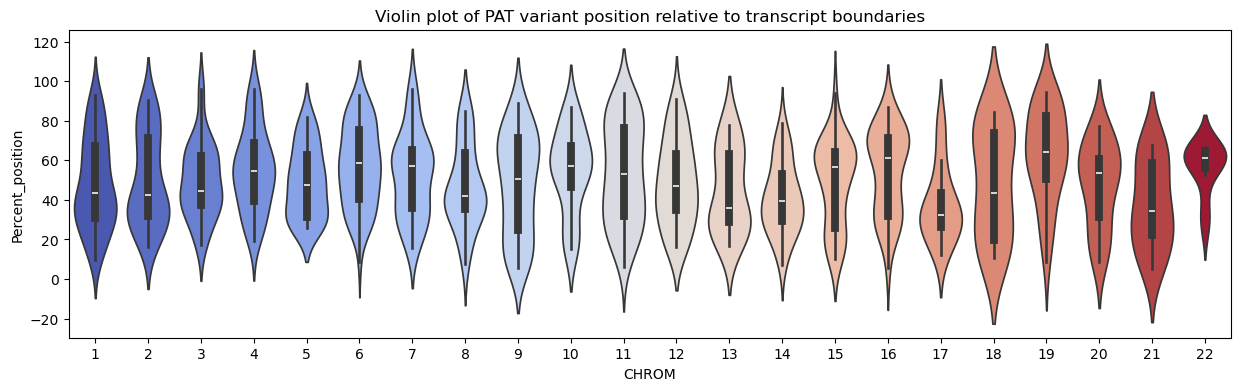

In [195]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=pat_nmd_escape_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of PAT variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

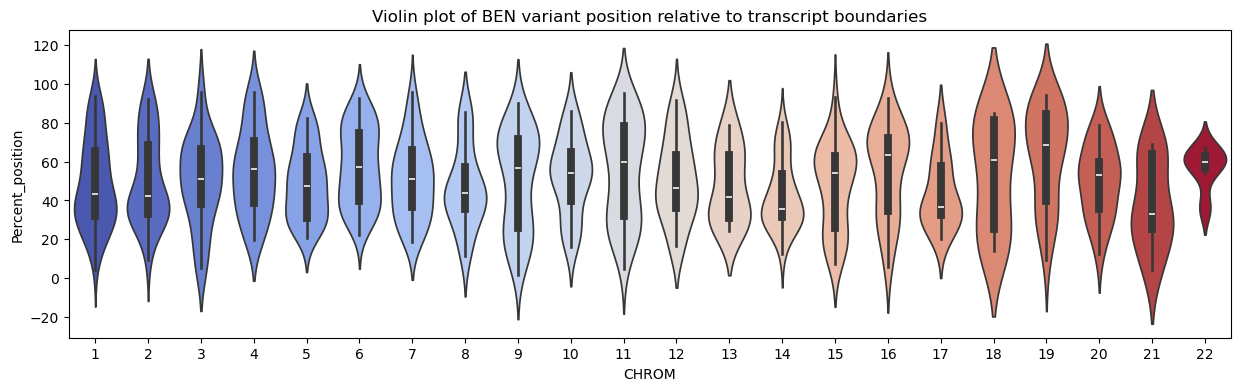

In [196]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=ben_nmd_escape_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

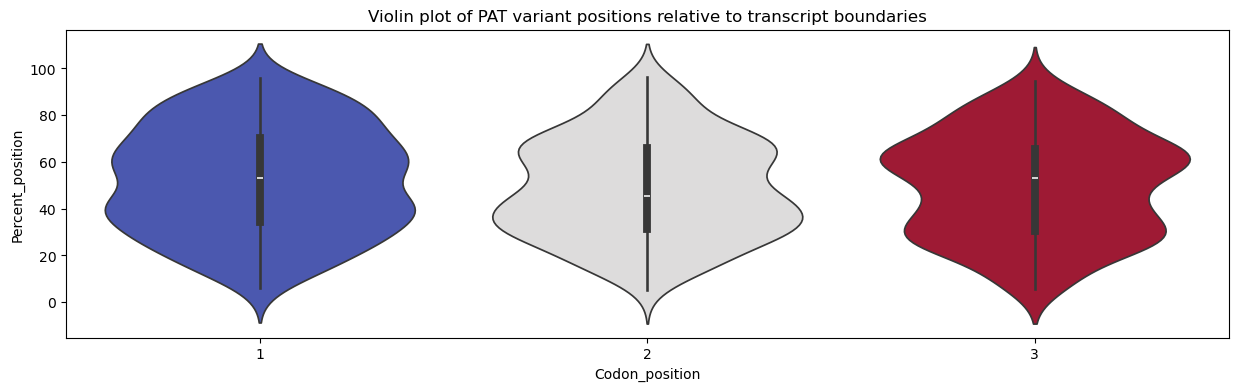

In [193]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='Codon_position', y='Percent_position', data=pat_nmd_escape_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
plt.title('Violin plot of PAT variant positions relative to transcript boundaries')
plt.xlabel('Codon_position')
plt.ylabel('Percent_position')
plt.show()

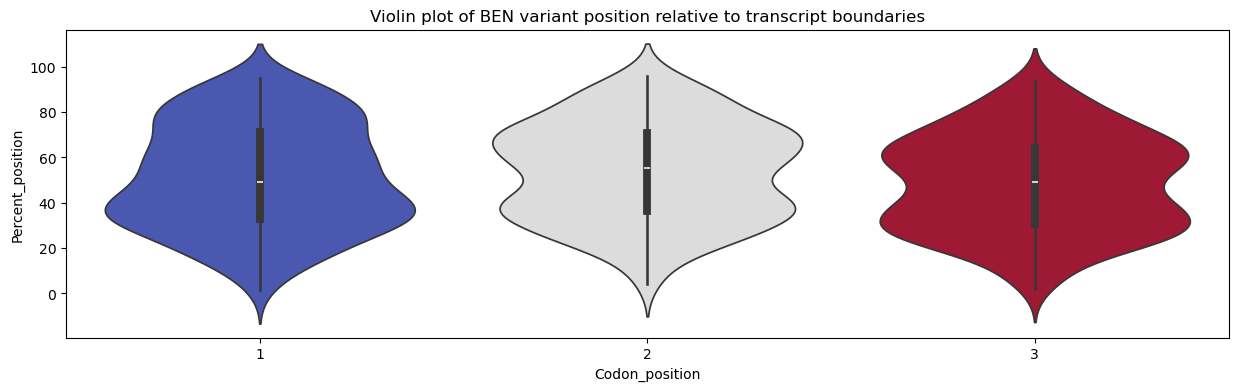

In [194]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='Codon_position', y='Percent_position', data=ben_nmd_escape_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('Codon_position')
plt.ylabel('Percent_position')
plt.show()

### Получение контекста последовательности

В таблице есть пустые поля в столбце `cDNA_position`, при итерации они отмечаются как `nan` (т.е. `<class 'float'>`). Если значение не пустое, оно имеет тип `str`, так что для работы `pyfaidx` приходится приводить его к `int`.

**Пропускаем позиции, которые слишком близко (`<=5`) к началу или концу транскрипта.**

Записываем контекст в отдельную колонку датафрейма.

In [102]:
def get_context(df, transcript_fasta, left_len, right_len):
    contexts = []

    for index, row in df.iterrows():
        transcript_id = row['Canonical_transcript']
        position_of_interest = row['cDNA_position']

        # Транскрипта может не быть в базе
        if transcript_id in transcript_fasta:
            transcript_length = len(transcript_fasta[transcript_id])

            # Не рассматриваем крайние случаи
            if left_len < position_of_interest < transcript_length - right_len:
                sequence_of_interest = str(transcript_fasta[transcript_id][position_of_interest - left_len: position_of_interest + right_len])
            else:
                sequence_of_interest = None
        else:
            sequence_of_interest = None
        
        contexts.append(sequence_of_interest)

    df['Context'] = contexts
    message = 'Contexts have been added to the dataframe!'

    return message

In [103]:
transcript_fasta = Fasta("data_dir/gencode_data/gencode.v45.transcripts.fa.gz", key_function = lambda x: x.split('.')[0])

Разделим датафреймы по положению варианта в кодоне.

In [104]:
ben_nmd_escape_final_1 = ben_nmd_escape_final.loc[ben_nmd_escape_final['Codon_position'] == 1].copy()
ben_nmd_escape_final_2 = ben_nmd_escape_final.loc[ben_nmd_escape_final['Codon_position'] == 2].copy()
ben_nmd_escape_final_3 = ben_nmd_escape_final.loc[ben_nmd_escape_final['Codon_position'] == 3].copy()

In [105]:
pat_nmd_escape_final_1 = pat_nmd_escape_final.loc[pat_nmd_escape_final['Codon_position'] == 1].copy()
pat_nmd_escape_final_2 = pat_nmd_escape_final.loc[pat_nmd_escape_final['Codon_position'] == 2].copy()
pat_nmd_escape_final_3 = pat_nmd_escape_final.loc[pat_nmd_escape_final['Codon_position'] == 3].copy()

Получим контексты:

In [106]:
get_context(ben_nmd_escape_final_1, transcript_fasta, 5, 7)
get_context(ben_nmd_escape_final_2, transcript_fasta, 6, 6)
get_context(ben_nmd_escape_final_3, transcript_fasta, 7, 5)

'Contexts have been added to the dataframe!'

In [107]:
get_context(pat_nmd_escape_final_1, transcript_fasta, 5, 7)
get_context(pat_nmd_escape_final_2, transcript_fasta, 6, 6)
get_context(pat_nmd_escape_final_3, transcript_fasta, 7, 5)

'Contexts have been added to the dataframe!'

### Проверим, точно ли всё правильно сделали при обработке датафрейма

In [218]:
pat_nmd_escape_final_1['Gene_symbol'].unique()

array(['AHNAK', 'USF3', 'KIAA2026', 'ANKRD50', 'DSP', 'TAF1L', 'TSHZ2',
       'ZNF318', 'FAT4', 'NWD2', 'LRRN1', 'LRRC8D', 'ZBTB21', 'ADCY9',
       'TOPORS', 'OTUD7A', 'TOX3', 'PHF3', 'PWWP2A', 'SLITRK3', 'GPATCH8',
       'PDZRN3', 'ZNF770', 'ZFHX3', 'BHLHE41', 'PPIG', 'RAPH1', 'TUBB3',
       'RBBP6', 'ZNFX1', 'NOTCH3', 'FAM171A1', 'TENM3', 'THAP12',
       'CDKN2AIP', 'DBF4', 'SIK2', 'ARHGAP31', 'MYO9A', 'LINGO1',
       'CACNA1A', 'ARHGAP21', 'LATS2', 'TRIO', 'KBTBD6', 'NCOR2', 'PPM1E',
       'ANKIB1', 'ROR1', 'TMEM185B', 'XKR6', 'MAGI2', 'COL6A1', 'RTN4RL1',
       'HS6ST3', 'ATF2', 'CACNA1I', 'BRINP2', 'DCAF5', 'ZKSCAN1', 'NUMBL',
       'CDH6', 'HIPK2', 'JADE1', 'SLC30A10', 'NSD1', 'SPRED1', 'PTGER4',
       'CDH8', 'NPAS3', 'PLAG1', 'ARFGEF3', 'ODF1', 'MTPAP', 'NFIB',
       'SPINDOC', 'AUTS2', 'SLK', 'TBX18', 'ARHGAP5', 'ERF', 'ABHD8',
       'NYAP1', 'KIAA0232', 'CFH', 'GGT7', 'ATG16L1', 'DIS3L2', 'GABBR2',
       'LEPR', 'TENT5C', 'NPAS2', 'HGF', 'FAR1', 'GRID2', 'FLT3',


##### Выбрали рандомный ген:

In [259]:
pat_nmd_escape_final_1[pat_nmd_escape_final_1['Gene_symbol'] == 'MED1']

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,NMD_escape,Codon_position,Context
1284,chr17,39407762,rs2048316694,G,A,HIGH,stop_gained,MED1,ENST00000300651,4660,HC,NaN,NaN,1.0,0.117,YES,1,TATCCGACCACT
1285,chr17,39409919,rs2048340153,G,A,HIGH,stop_gained,MED1,ENST00000300651,2503,HC,NaN,NaN,1.0,0.117,YES,1,GGTCCGACTATC


##### Проверяем каждый вариант на соответствие контексту и чекаем всё ли ок в гномаде:

https://gnomad.broadinstitute.org/variant/17-39407762-G-A?dataset=gnomad_r4

In [265]:
transcript_fasta['ENST00000300651'][4660 - 5 : 4660 + 7]

>ENST00000300651:4656-4667
TATCCGACCACT

In [271]:
transcript_651 = transcript_fasta['ENST00000300651']

In [272]:
print(transcript_651[4660 - 5 : 4660 + 7])

TATCCGACCACT


https://gnomad.broadinstitute.org/variant/17-39409919-G-A?dataset=gnomad_r4

<font color="red"> Здесь по ссылке стоит AC = 2, а у нас в таблице 1.  
В экзомах и правда 1 аллель, а ещё 1 в геномах.

In [269]:
transcript_fasta['ENST00000300651'][2503 - 5 : 2503 + 7]

>ENST00000300651:2499-2510
GGTCCGACTATC

In [273]:
print(transcript_651[2503 - 5 : 2503 + 7])

GGTCCGACTATC


##### Проверяем LOEUF в словаре и напрямую в сыром файле с plof_metrics:

In [275]:
loeuf_by_transcript_dict['ENST00000300651']

0.117

In [276]:
header_plof = [
    "gene", "transcript", "obs_mis", "exp_mis", "oe_mis", "mu_mis", "possible_mis",
    "obs_mis_pphen", "exp_mis_pphen", "oe_mis_pphen", "possible_mis_pphen", "obs_syn",
    "exp_syn", "oe_syn", "mu_syn", "possible_syn", "obs_lof", "mu_lof", "possible_lof",
    "exp_lof", "pLI", "pNull", "pRec", "oe_lof", "oe_syn_lower", "oe_syn_upper",
    "oe_mis_lower", "oe_mis_upper", "oe_lof_lower", "oe_lof_upper", "constraint_flag",
    "syn_z", "mis_z", "lof_z", "oe_lof_upper_rank", "oe_lof_upper_bin",
    "oe_lof_upper_bin_6", "n_sites", "classic_caf", "max_af", "no_lofs", "obs_het_lof",
    "obs_hom_lof", "defined", "p", "exp_hom_lof", "classic_caf_afr", "classic_caf_amr",
    "classic_caf_asj", "classic_caf_eas", "classic_caf_fin", "classic_caf_nfe",
    "classic_caf_oth", "classic_caf_sas", "p_afr", "p_amr", "p_asj", "p_eas", "p_fin",
    "p_nfe", "p_oth", "p_sas", "transcript_type", "gene_id", "transcript_level",
    "cds_length", "num_coding_exons", "gene_type", "gene_length", "exac_pLI",
    "exac_obs_lof", "exac_exp_lof", "exac_oe_lof", "brain_expression", "chromosome",
    "start_position", "end_position"
]

In [277]:
ENST00000300651_plof_df = pd.read_table("data_dir/ENST00000300651_plof.txt", names=header_plof)
ENST00000300651_plof_df['oe_lof_upper']
# oe_Lof_Upper: LOEUF: Upper bound of 90% confidence interval for o/e ratio for pLoF (predicted loss-of-function) variants. 

0    0.117
Name: oe_lof_upper, dtype: float64

##### Является ли NMD-escaped:

In [260]:
nmd_bed_df[nmd_bed_df['transcript'].str.contains('ENST00000300651')]

,chrom,start,end,cds_id,score,strand,transcript,cds_size
13951,chr17,39407477,39410721,ENST00000300651.11_cds_0_0_chr17_39407478_r,.,-,ENST00000300651.11,3244
13952,chr17,39415025,39415080,ENST00000300651.11_cds_0_0_chr17_39415026_r,.,-,ENST00000300651.11,55


In [261]:
( 39407477 <= 39407762 <= 39410721 ) or ( 39415025 <= 39407762 <= 39415080 )

True

In [262]:
( 39407477 <= 39409919 <= 39410721 ) or ( 39415025 <= 39409919 <= 39415080 )

True

##### Всё то же самое проделано для 2х вариантов в гене _SLIT3_, всё ок (не сохраняла, чтобы не засорять ноутбук).

### Построение лого с помощью logomaker

https://github.com/jbkinney/logomaker/blob/master/logomaker/tutorials

https://logomaker.readthedocs.io/en/latest/

Сам всё делает, надо только подать список последовательностей, удалив пустые значения.

In [108]:
def filter_and_convert_to_list(column):
    filtered_list = column.tolist()
    filtered_list = list(filter(None, filtered_list))
    return filtered_list

In [109]:
filtered_context_ben_1 = filter_and_convert_to_list(ben_nmd_escape_final_1['Context'])
filtered_context_ben_2 = filter_and_convert_to_list(ben_nmd_escape_final_2['Context'])
filtered_context_ben_3 = filter_and_convert_to_list(ben_nmd_escape_final_3['Context'])

In [110]:
filtered_context_pat_1 = filter_and_convert_to_list(pat_nmd_escape_final_1['Context'])
filtered_context_pat_2 = filter_and_convert_to_list(pat_nmd_escape_final_2['Context'])
filtered_context_pat_3 = filter_and_convert_to_list(pat_nmd_escape_final_3['Context'])

Строим матрицы.

In [111]:
counts_mat_pat_1 = lm.alignment_to_matrix(filtered_context_pat_1)
counts_mat_ben_1 = lm.alignment_to_matrix(filtered_context_ben_1)

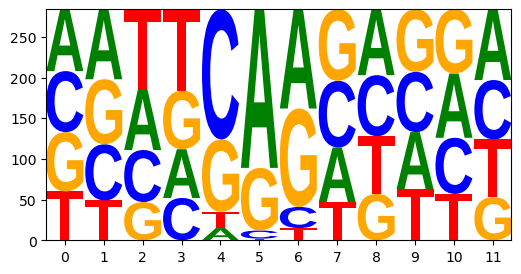

In [112]:
pat_logo = lm.Logo(counts_mat_pat_1, 
                   figsize=(6, 3),
                   font_name='Liberation Sans')
pat_logo.style_xticks()

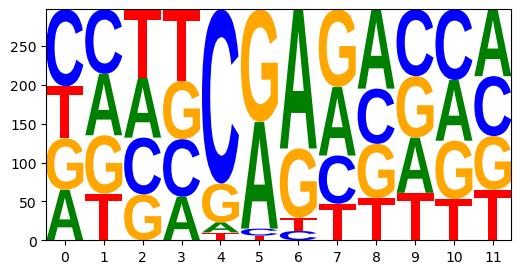

In [113]:
ben_logo = lm.Logo(counts_mat_ben_1, 
                   figsize=(6, 3),
                   font_name='Liberation Sans')
ben_logo.style_xticks()

Окрашивание по base_pairing:

In [114]:
# pat_logo = lm.Logo(counts_mat_pat, 
#                    figsize=(6, 3),
#                    color_scheme='base_pairing',
#                    font_name='Liberation Sans')
# pat_logo.style_xticks()

# ben_logo = lm.Logo(counts_mat_ben, 
#                    figsize=(6, 3),
#                    color_scheme='base_pairing',
#                    font_name='Liberation Sans')
# ben_logo.style_xticks()

Можно ещё по вероятностям строить:

In [115]:
# prob_mat_pat = lm.transform_matrix(counts_mat_pat, from_type='counts', to_type='probability')
# prob_mat_ben = lm.transform_matrix(counts_mat_ben, from_type='counts', to_type='probability')

### Статистическое сравнение позиций в контекстах

Виды позиционных матриц:  

**Position Frequency Matrix (PFM)**:  
В ячейках PFM содержатся частоты каждого нуклеотида на соответствующей позиции в наборе последовательностей.
PFM не нормализуется по вероятностям, поэтому сумма значений в каждой строке может быть больше 1.  
  
**Position Probability Matrix (PPM)**:  
В отличие от PFM, значения в PPM нормализуются по вероятностям, так что сумма значений в каждой строке равна 1.
PPM показывает вероятность появления каждого нуклеотида на каждой позиции в последовательности.  

**Position Weight Matrix (PWM)**:  
Значения в PWM выражены в виде весов, которые показывают предпочтительность каждого нуклеотида на каждой позиции. Веса обычно вычисляются как логарифм отношения частоты наблюдения нуклеотида к ожидаемой частоте нуклеотида на данной позиции.

Считаем хи-квадраты для каждой позиции при сравнении двух матриц:

In [116]:
def calculate_chi2_p_values(context_ben, context_pat):
    # Преобразование списка контекстов в массив нампай
    sequences_array_ben = np.array(context_ben)
    sequences_array_pat = np.array(context_pat)

    # Создание пустого массива для хранения частот
    freq_array_ben = np.zeros((len(sequences_array_ben[0]), 4))
    freq_array_pat = np.zeros((len(sequences_array_pat[0]), 4))

    # Вычисление частоты каждой буквы на каждой позиции
    for seq in sequences_array_ben:
        for j, nt in enumerate(seq):
            if nt == 'A':
                freq_array_ben[j][0] += 1
            elif nt == 'C':
                freq_array_ben[j][1] += 1
            elif nt == 'G':
                freq_array_ben[j][2] += 1
            elif nt == 'T':
                freq_array_ben[j][3] += 1

    for seq in sequences_array_pat:
        for j, nt in enumerate(seq):
            if nt == 'A':
                freq_array_pat[j][0] += 1
            elif nt == 'C':
                freq_array_pat[j][1] += 1
            elif nt == 'G':
                freq_array_pat[j][2] += 1
            elif nt == 'T':
                freq_array_pat[j][3] += 1

    chi2_values = []
    p_values = []

    for i in range(freq_array_pat.shape[0]):
        # Таблица сопряженности для каждой текущей позиции (строки в массиве)
        contingency_table = np.array([freq_array_pat[i], freq_array_ben[i]])
        # Два пропуска, т.к. chi2_contingency возвращает statistic, pvalue, dof и expected_freq
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        chi2_values.append(chi2)
        p_values.append(p_value)

    return chi2_values, p_values


In [117]:
chi2_values, p_values = calculate_chi2_p_values(filtered_context_ben_1, filtered_context_pat_1)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 5:
        print("==="*25)
    if counter == 6:
        print("==="*25)

Position 0: Chi-square = 4.618279959347513, p-value = 0.20197953142051672
Position 1: Chi-square = 2.5682334366976853, p-value = 0.4630858714446292
Position 2: Chi-square = 2.2239172478565266, p-value = 0.5272527962694449
Position 3: Chi-square = 4.08492602122533, p-value = 0.25243847617502085
Position 4: Chi-square = 24.806844942313326, p-value = 1.6944994617991293e-05
Position 5: Chi-square = 32.73950377219775, p-value = 3.6550046474914355e-07
Position 6: Chi-square = 20.672577080627846, p-value = 0.0001231132709277446
Position 7: Chi-square = 6.101073221858113, p-value = 0.10679501249924954
Position 8: Chi-square = 5.874196889342991, p-value = 0.11789383867305177
Position 9: Chi-square = 0.6744511559785942, p-value = 0.8791961993642913
Position 10: Chi-square = 2.9913398942747595, p-value = 0.3929623223412432
Position 11: Chi-square = 2.1857300409738913, p-value = 0.5347645747654715


In [118]:
chi2_values, p_values = calculate_chi2_p_values(filtered_context_ben_2, filtered_context_pat_2)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 6:
        print("==="*25)
    if counter == 7:
        print("==="*25)

Position 0: Chi-square = 0.849123390461066, p-value = 0.8376848153472573
Position 1: Chi-square = 4.764891120667462, p-value = 0.18984498833014443
Position 2: Chi-square = 0.5189922930661566, p-value = 0.9146995091078781
Position 3: Chi-square = 1.0265969919544775, p-value = 0.7948166378863893
Position 4: Chi-square = 8.811956061018602, p-value = 0.031898382686074526
Position 5: Chi-square = 22.77810757090686, p-value = 4.492007800045781e-05
Position 6: Chi-square = 29.801342980917173, p-value = 1.519428062634677e-06
Position 7: Chi-square = 23.8136323097738, p-value = 2.732089512612129e-05
Position 8: Chi-square = 4.658006182549219, p-value = 0.19862213075114202
Position 9: Chi-square = 2.0694602409171727, p-value = 0.558115829310144
Position 10: Chi-square = 2.040424206212692, p-value = 0.564059042991605
Position 11: Chi-square = 1.3585880323235338, p-value = 0.7152699764854662


In [119]:
chi2_values, p_values = calculate_chi2_p_values(filtered_context_ben_3, filtered_context_pat_3)
counter = 0
for i, (chi2, p_value) in enumerate(zip(chi2_values, p_values)):
    print(f"Position {i}: Chi-square = {chi2}, p-value = {p_value}")
    counter += 1
    if counter == 7:
        print("==="*25)
    if counter == 8:
        print("==="*25)

Position 0: Chi-square = 5.89672078681976, p-value = 0.11674453691371792
Position 1: Chi-square = 2.771672275711542, p-value = 0.4281844194112039
Position 2: Chi-square = 2.577006291316112, p-value = 0.4615349081246579
Position 3: Chi-square = 2.958018652877037, p-value = 0.398143267480361
Position 4: Chi-square = 2.100036269550125, p-value = 0.5519054257974891
Position 5: Chi-square = 7.165314068603944, p-value = 0.06681120509168807
Position 6: Chi-square = 21.37433745635674, p-value = 8.801593109696518e-05
Position 7: Chi-square = 53.545156245633976, p-value = 1.4028528871961152e-11
Position 8: Chi-square = 24.866874262463465, p-value = 1.646240135149899e-05
Position 9: Chi-square = 7.398112082944618, p-value = 0.060234999196481495
Position 10: Chi-square = 3.6027406006018556, p-value = 0.30767943369004386
Position 11: Chi-square = 19.306427874090087, p-value = 0.00023627351637019972


Так было до фильтрации по pext (>0.5):

#### **seqlogo**

https://pypi.org/project/seqlogo/

Можно ещё логотипы строить через библиотеку seqlogo. Но ей нужно подавать уже готовую матрицу (пример выше).

In [120]:
# ppm_pat = seqlogo.Ppm(freq_array_pat)
# ppm_ben = seqlogo.Ppm(freq_array_ben)

# seqlogo.seqlogo(ppm_pat, ic_scale = False, format = 'svg', size = 'medium')
# seqlogo.seqlogo(ppm_ben, ic_scale = False, format = 'svg', size = 'medium')